In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 2000
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
MAIN_DIR = os.getcwd() + "\\Brain_Tumor_MRI_Dataset\\yes"

In [4]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [5]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

In [6]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [7]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

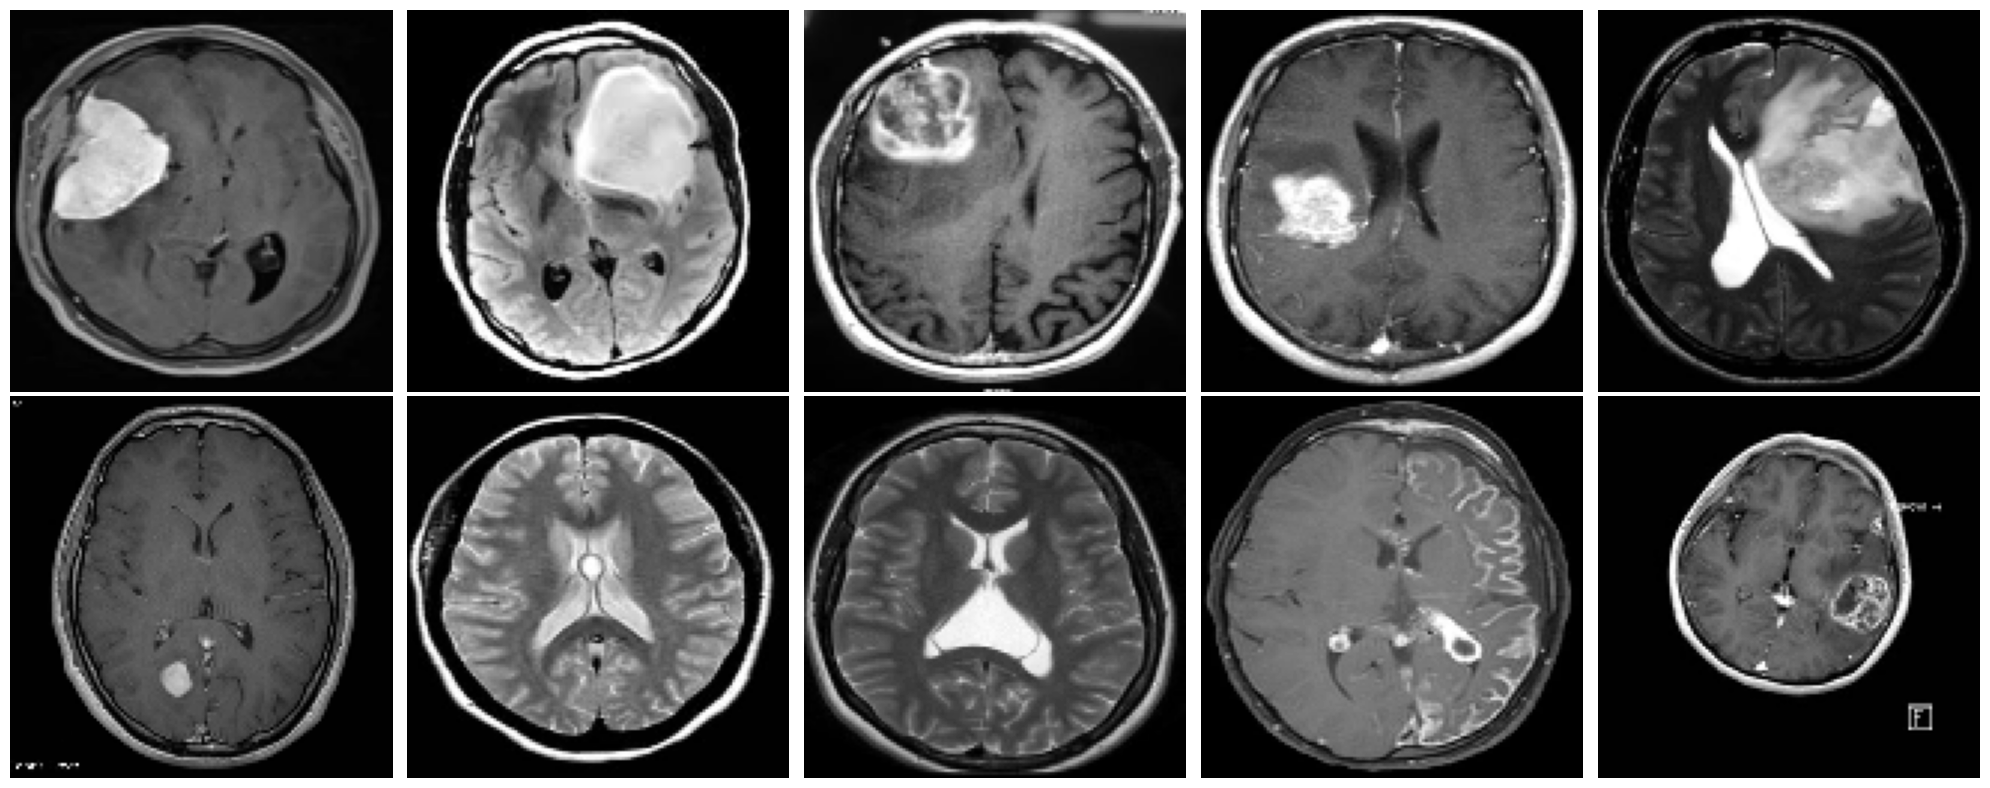

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,785 (2.22 MB)

 Trainable params: 582,785 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 262144)         │    26,476,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265,281 (104.01 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 0 (0.00 B)

The Combined Network:



Model: "gan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 128, 128, 1)    │    27,265,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │       582,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,848,066 (106.23 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 582,785 (2.22 MB)

In [13]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

  0%|                                                 | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|                                       | 1/2000 [00:01<1:04:09,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|                                         | 2/2000 [00:02<44:28,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  0%|                                         | 3/2000 [00:03<38:23,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  0%|                                         | 4/2000 [00:04<34:57,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  0%|                                         | 5/2000 [00:05<34:06,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  0%|                                         | 6/2000 [00:06<31:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  0%|▏                                        | 7/2000 [00:07<30:43,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  0%|▏                                        | 8/2000 [00:08<30:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  0%|▏                                        | 9/2000 [00:09<29:26,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|▏                                       | 10/2000 [00:09<29:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  1%|▏                                       | 11/2000 [00:10<28:57,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|▏                                       | 12/2000 [00:11<28:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  1%|▎                                       | 13/2000 [00:12<28:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  1%|▎                                       | 14/2000 [00:13<29:11,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  1%|▎                                       | 15/2000 [00:14<29:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  1%|▎                                       | 16/2000 [00:15<29:34,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  1%|▎                                       | 17/2000 [00:16<29:17,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  1%|▎                                       | 18/2000 [00:16<29:12,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  1%|▍                                       | 19/2000 [00:17<28:07,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  1%|▍                                       | 20/2000 [00:18<27:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▍                                       | 21/2000 [00:19<27:50,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|▍                                       | 22/2000 [00:20<28:39,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|▍                                       | 23/2000 [00:21<29:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  1%|▍                                       | 24/2000 [00:22<28:29,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  1%|▌                                       | 25/2000 [00:22<28:34,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  1%|▌                                       | 26/2000 [00:23<28:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  1%|▌                                       | 27/2000 [00:24<28:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  1%|▌                                       | 28/2000 [00:25<28:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|▌                                       | 29/2000 [00:26<28:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|▌                                       | 30/2000 [00:27<29:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  2%|▌                                       | 31/2000 [00:28<29:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  2%|▋                                       | 32/2000 [00:29<29:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|▋                                       | 33/2000 [00:30<29:46,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  2%|▋                                       | 34/2000 [00:31<29:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  2%|▋                                       | 35/2000 [00:31<28:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  2%|▋                                       | 36/2000 [00:32<29:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▋                                       | 37/2000 [00:33<28:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  2%|▊                                       | 38/2000 [00:34<28:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  2%|▊                                       | 39/2000 [00:35<28:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  2%|▊                                       | 40/2000 [00:36<28:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  2%|▊                                       | 41/2000 [00:37<30:40,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  2%|▊                                       | 42/2000 [00:38<30:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|▊                                       | 43/2000 [00:39<30:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  2%|▉                                       | 44/2000 [00:40<29:45,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  2%|▉                                       | 45/2000 [00:40<29:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  2%|▉                                       | 46/2000 [00:41<28:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  2%|▉                                       | 47/2000 [00:42<28:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|▉                                       | 48/2000 [00:43<29:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|▉                                       | 49/2000 [00:44<30:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  2%|█                                       | 50/2000 [00:45<29:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  3%|█                                       | 51/2000 [00:46<29:25,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  3%|█                                       | 52/2000 [00:47<29:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|█                                       | 53/2000 [00:48<29:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  3%|█                                       | 54/2000 [00:49<29:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  3%|█                                       | 55/2000 [00:50<29:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  3%|█                                       | 56/2000 [00:50<29:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|█▏                                      | 57/2000 [00:51<29:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  3%|█▏                                      | 58/2000 [00:52<29:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  3%|█▏                                      | 59/2000 [00:53<29:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|█▏                                      | 60/2000 [00:54<29:07,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|█▏                                      | 61/2000 [00:55<29:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  3%|█▏                                      | 62/2000 [00:56<28:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  3%|█▎                                      | 63/2000 [00:57<28:42,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  3%|█▎                                      | 64/2000 [00:58<27:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  3%|█▎                                      | 65/2000 [00:58<27:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  3%|█▎                                      | 66/2000 [00:59<27:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  3%|█▎                                      | 67/2000 [01:00<28:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  3%|█▎                                      | 68/2000 [01:01<28:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  3%|█▍                                      | 69/2000 [01:02<29:08,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  4%|█▍                                      | 70/2000 [01:03<28:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  4%|█▍                                      | 71/2000 [01:04<28:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|█▍                                      | 72/2000 [01:05<29:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  4%|█▍                                      | 73/2000 [01:06<28:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  4%|█▍                                      | 74/2000 [01:07<29:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  4%|█▌                                      | 75/2000 [01:07<28:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  4%|█▌                                      | 76/2000 [01:08<28:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  4%|█▌                                      | 77/2000 [01:09<28:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  4%|█▌                                      | 78/2000 [01:10<28:08,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|█▌                                      | 79/2000 [01:11<28:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  4%|█▌                                      | 80/2000 [01:12<28:38,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  4%|█▌                                      | 81/2000 [01:13<29:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  4%|█▋                                      | 82/2000 [01:14<29:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  4%|█▋                                      | 83/2000 [01:15<29:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  4%|█▋                                      | 84/2000 [01:16<29:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  4%|█▋                                      | 85/2000 [01:16<28:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  4%|█▋                                      | 86/2000 [01:17<28:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  4%|█▋                                      | 87/2000 [01:18<28:12,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  4%|█▊                                      | 88/2000 [01:19<27:42,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  4%|█▊                                      | 89/2000 [01:20<28:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  4%|█▊                                      | 90/2000 [01:21<28:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  5%|█▊                                      | 91/2000 [01:22<27:57,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  5%|█▊                                      | 92/2000 [01:23<28:36,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  5%|█▊                                      | 93/2000 [01:24<28:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  5%|█▉                                      | 94/2000 [01:24<28:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  5%|█▉                                      | 95/2000 [01:25<27:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  5%|█▉                                      | 96/2000 [01:26<28:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  5%|█▉                                      | 97/2000 [01:27<27:18,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  5%|█▉                                      | 98/2000 [01:28<27:15,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  5%|█▉                                      | 99/2000 [01:29<28:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  5%|█▉                                     | 100/2000 [01:30<27:20,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  5%|█▉                                     | 101/2000 [01:30<27:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  5%|█▉                                     | 102/2000 [01:31<27:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  5%|██                                     | 103/2000 [01:32<27:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  5%|██                                     | 104/2000 [01:33<27:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  5%|██                                     | 105/2000 [01:34<28:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


  5%|██                                     | 106/2000 [01:35<28:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  5%|██                                     | 107/2000 [01:36<28:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  5%|██                                     | 108/2000 [01:37<28:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  5%|██▏                                    | 109/2000 [01:38<28:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  6%|██▏                                    | 110/2000 [01:39<28:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|██▏                                    | 111/2000 [01:40<29:07,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|██▏                                    | 112/2000 [01:41<29:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  6%|██▏                                    | 113/2000 [01:41<28:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  6%|██▏                                    | 114/2000 [01:42<28:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  6%|██▏                                    | 115/2000 [01:43<28:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  6%|██▎                                    | 116/2000 [01:44<28:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  6%|██▎                                    | 117/2000 [01:45<28:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  6%|██▎                                    | 118/2000 [01:46<28:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  6%|██▎                                    | 119/2000 [01:47<28:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  6%|██▎                                    | 120/2000 [01:48<28:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|██▎                                    | 121/2000 [01:49<28:21,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  6%|██▍                                    | 122/2000 [01:49<27:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  6%|██▍                                    | 123/2000 [01:50<27:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  6%|██▍                                    | 124/2000 [01:51<28:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  6%|██▍                                    | 125/2000 [01:52<27:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  6%|██▍                                    | 126/2000 [01:53<27:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  6%|██▍                                    | 127/2000 [01:54<27:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  6%|██▍                                    | 128/2000 [01:55<28:07,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  6%|██▌                                    | 129/2000 [01:56<28:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|██▌                                    | 130/2000 [01:57<28:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  7%|██▌                                    | 131/2000 [01:58<28:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  7%|██▌                                    | 132/2000 [01:58<28:17,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  7%|██▌                                    | 133/2000 [01:59<27:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  7%|██▌                                    | 134/2000 [02:00<28:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|██▋                                    | 135/2000 [02:01<28:16,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  7%|██▋                                    | 136/2000 [02:02<28:22,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  7%|██▋                                    | 137/2000 [02:03<28:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  7%|██▋                                    | 138/2000 [02:04<28:17,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|██▋                                    | 139/2000 [02:05<28:10,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|██▋                                    | 140/2000 [02:06<28:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  7%|██▋                                    | 141/2000 [02:07<28:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  7%|██▊                                    | 142/2000 [02:08<28:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  7%|██▊                                    | 143/2000 [02:08<27:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


  7%|██▊                                    | 144/2000 [02:09<27:53,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  7%|██▊                                    | 145/2000 [02:10<27:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  7%|██▊                                    | 146/2000 [02:11<28:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  7%|██▊                                    | 147/2000 [02:12<27:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  7%|██▉                                    | 148/2000 [02:13<27:43,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|██▉                                    | 149/2000 [02:14<28:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|██▉                                    | 150/2000 [02:15<27:59,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██▉                                    | 151/2000 [02:16<27:38,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  8%|██▉                                    | 152/2000 [02:17<27:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██▉                                    | 153/2000 [02:17<27:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  8%|███                                    | 154/2000 [02:18<27:17,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  8%|███                                    | 155/2000 [02:19<26:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  8%|███                                    | 156/2000 [02:20<27:52,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


  8%|███                                    | 157/2000 [02:21<28:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  8%|███                                    | 158/2000 [02:22<28:50,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  8%|███                                    | 159/2000 [02:23<28:42,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|███                                    | 160/2000 [02:24<28:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  8%|███▏                                   | 161/2000 [02:25<28:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  8%|███▏                                   | 162/2000 [02:26<27:46,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  8%|███▏                                   | 163/2000 [02:27<27:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  8%|███▏                                   | 164/2000 [02:28<27:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|███▏                                   | 165/2000 [02:29<28:18,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  8%|███▏                                   | 166/2000 [02:29<28:27,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  8%|███▎                                   | 167/2000 [02:30<28:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  8%|███▎                                   | 168/2000 [02:31<27:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  8%|███▎                                   | 169/2000 [02:32<28:12,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  8%|███▎                                   | 170/2000 [02:33<27:21,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|███▎                                   | 171/2000 [02:34<27:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  9%|███▎                                   | 172/2000 [02:35<27:20,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  9%|███▎                                   | 173/2000 [02:36<27:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|███▍                                   | 174/2000 [02:37<27:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  9%|███▍                                   | 175/2000 [02:38<27:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  9%|███▍                                   | 176/2000 [02:39<30:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  9%|███▍                                   | 177/2000 [02:40<29:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|███▍                                   | 178/2000 [02:41<28:55,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  9%|███▍                                   | 179/2000 [02:42<29:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  9%|███▌                                   | 180/2000 [02:43<29:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  9%|███▌                                   | 181/2000 [02:43<28:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  9%|███▌                                   | 182/2000 [02:44<28:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  9%|███▌                                   | 183/2000 [02:45<27:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  9%|███▌                                   | 184/2000 [02:46<27:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  9%|███▌                                   | 185/2000 [02:47<28:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  9%|███▋                                   | 186/2000 [02:48<28:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|███▋                                   | 187/2000 [02:49<28:40,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  9%|███▋                                   | 188/2000 [02:50<28:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  9%|███▋                                   | 189/2000 [02:51<27:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 10%|███▋                                   | 190/2000 [02:52<27:24,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 10%|███▋                                   | 191/2000 [02:53<28:20,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 10%|███▋                                   | 192/2000 [02:54<29:28,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 10%|███▊                                   | 193/2000 [02:55<29:10,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███▊                                   | 194/2000 [02:56<29:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 10%|███▊                                   | 195/2000 [02:57<27:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 10%|███▊                                   | 196/2000 [02:58<28:19,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 10%|███▊                                   | 197/2000 [02:58<28:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 10%|███▊                                   | 198/2000 [02:59<28:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 10%|███▉                                   | 199/2000 [03:00<27:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 10%|███▉                                   | 200/2000 [03:01<27:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 10%|███▉                                   | 201/2000 [03:02<28:56,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 10%|███▉                                   | 202/2000 [03:03<28:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|███▉                                   | 203/2000 [03:04<28:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 10%|███▉                                   | 204/2000 [03:05<28:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 10%|███▉                                   | 205/2000 [03:06<28:42,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 10%|████                                   | 206/2000 [03:07<28:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 10%|████                                   | 207/2000 [03:08<28:12,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 10%|████                                   | 208/2000 [03:09<28:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|████                                   | 209/2000 [03:10<28:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 10%|████                                   | 210/2000 [03:11<28:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████                                   | 211/2000 [03:12<29:40,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 11%|████▏                                  | 212/2000 [03:13<29:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 11%|████▏                                  | 213/2000 [03:14<29:45,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████▏                                  | 214/2000 [03:15<29:44,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 11%|████▏                                  | 215/2000 [03:16<29:28,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 11%|████▏                                  | 216/2000 [03:17<29:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████▏                                  | 217/2000 [03:18<29:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 11%|████▎                                  | 218/2000 [03:19<29:13,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|████▎                                  | 219/2000 [03:20<28:12,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 11%|████▎                                  | 220/2000 [03:21<29:36,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 11%|████▎                                  | 221/2000 [03:22<28:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 11%|████▎                                  | 222/2000 [03:23<27:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 11%|████▎                                  | 223/2000 [03:24<28:01,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 11%|████▎                                  | 224/2000 [03:25<28:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 11%|████▍                                  | 225/2000 [03:25<27:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████▍                                  | 226/2000 [03:26<28:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 11%|████▍                                  | 227/2000 [03:27<27:33,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|████▍                                  | 228/2000 [03:28<27:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|████▍                                  | 229/2000 [03:29<27:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|████▍                                  | 230/2000 [03:30<27:33,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|████▌                                  | 231/2000 [03:31<28:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████▌                                  | 232/2000 [03:32<28:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 12%|████▌                                  | 233/2000 [03:33<28:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 12%|████▌                                  | 234/2000 [03:34<28:50,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|████▌                                  | 235/2000 [03:35<27:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 12%|████▌                                  | 236/2000 [03:36<27:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 12%|████▌                                  | 237/2000 [03:37<26:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 12%|████▋                                  | 238/2000 [03:38<27:20,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 12%|████▋                                  | 239/2000 [03:39<27:40,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 12%|████▋                                  | 240/2000 [03:40<27:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 12%|████▋                                  | 241/2000 [03:40<26:59,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 12%|████▋                                  | 242/2000 [03:41<26:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 12%|████▋                                  | 243/2000 [03:42<26:28,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|████▊                                  | 244/2000 [03:43<26:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|████▊                                  | 245/2000 [03:44<27:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 12%|████▊                                  | 246/2000 [03:45<27:41,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 12%|████▊                                  | 247/2000 [03:46<27:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 12%|████▊                                  | 248/2000 [03:47<28:22,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 12%|████▊                                  | 249/2000 [03:48<27:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|████▉                                  | 250/2000 [03:49<28:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|████▉                                  | 251/2000 [03:50<27:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 13%|████▉                                  | 252/2000 [03:51<28:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 13%|████▉                                  | 253/2000 [03:52<28:43,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 13%|████▉                                  | 254/2000 [03:53<27:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 13%|████▉                                  | 255/2000 [03:54<29:09,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 13%|████▉                                  | 256/2000 [03:55<28:54,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█████                                  | 257/2000 [03:56<28:43,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 13%|█████                                  | 258/2000 [03:57<27:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 13%|█████                                  | 259/2000 [03:58<27:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 13%|█████                                  | 260/2000 [03:59<28:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 13%|█████                                  | 261/2000 [04:00<27:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|█████                                  | 262/2000 [04:01<27:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 13%|█████▏                                 | 263/2000 [04:02<27:35,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 13%|█████▏                                 | 264/2000 [04:03<27:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█████▏                                 | 265/2000 [04:03<27:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 13%|█████▏                                 | 266/2000 [04:04<27:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████▏                                 | 267/2000 [04:05<27:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 13%|█████▏                                 | 268/2000 [04:06<28:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 13%|█████▏                                 | 269/2000 [04:07<28:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 14%|█████▎                                 | 270/2000 [04:08<28:55,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 14%|█████▎                                 | 271/2000 [04:09<28:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 14%|█████▎                                 | 272/2000 [04:10<28:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 14%|█████▎                                 | 273/2000 [04:11<28:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 14%|█████▎                                 | 274/2000 [04:12<27:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 14%|█████▎                                 | 275/2000 [04:13<27:59,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 14%|█████▍                                 | 276/2000 [04:14<28:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 14%|█████▍                                 | 277/2000 [04:15<28:14,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 14%|█████▍                                 | 278/2000 [04:16<28:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 14%|█████▍                                 | 279/2000 [04:17<28:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 14%|█████▍                                 | 280/2000 [04:18<28:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 14%|█████▍                                 | 281/2000 [04:19<28:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 14%|█████▍                                 | 282/2000 [04:20<29:13,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 14%|█████▌                                 | 283/2000 [04:21<28:38,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 14%|█████▌                                 | 284/2000 [04:22<27:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 14%|█████▌                                 | 285/2000 [04:23<27:55,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 14%|█████▌                                 | 286/2000 [04:24<27:50,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 14%|█████▌                                 | 287/2000 [04:25<27:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 14%|█████▌                                 | 288/2000 [04:26<28:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 14%|█████▋                                 | 289/2000 [04:27<28:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 14%|█████▋                                 | 290/2000 [04:28<28:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 15%|█████▋                                 | 291/2000 [04:29<28:27,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|█████▋                                 | 292/2000 [04:30<28:08,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 15%|█████▋                                 | 293/2000 [04:31<28:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 15%|█████▋                                 | 294/2000 [04:32<28:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 15%|█████▊                                 | 295/2000 [04:33<27:54,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 15%|█████▊                                 | 296/2000 [04:34<28:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 15%|█████▊                                 | 297/2000 [04:35<28:52,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 15%|█████▊                                 | 298/2000 [04:36<28:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 15%|█████▊                                 | 299/2000 [04:37<29:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 15%|█████▊                                 | 300/2000 [04:38<29:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 15%|█████▊                                 | 301/2000 [04:39<29:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 15%|█████▉                                 | 302/2000 [04:40<28:26,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 15%|█████▉                                 | 303/2000 [04:41<28:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|█████▉                                 | 304/2000 [04:42<27:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 15%|█████▉                                 | 305/2000 [04:43<27:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|█████▉                                 | 306/2000 [04:44<27:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 15%|█████▉                                 | 307/2000 [04:45<28:17,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 15%|██████                                 | 308/2000 [04:46<27:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 15%|██████                                 | 309/2000 [04:47<27:25,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 16%|██████                                 | 310/2000 [04:48<27:50,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 16%|██████                                 | 311/2000 [04:49<28:34,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 16%|██████                                 | 312/2000 [04:50<29:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 16%|██████                                 | 313/2000 [04:51<28:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 16%|██████                                 | 314/2000 [04:52<28:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|██████▏                                | 315/2000 [04:53<28:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 16%|██████▏                                | 316/2000 [04:54<27:53,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 16%|██████▏                                | 317/2000 [04:55<27:26,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 16%|██████▏                                | 318/2000 [04:56<27:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 16%|██████▏                                | 319/2000 [04:57<28:05,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 16%|██████▏                                | 320/2000 [04:58<27:44,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 16%|██████▎                                | 321/2000 [04:59<27:34,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 16%|██████▎                                | 322/2000 [05:00<28:25,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|██████▎                                | 323/2000 [05:01<28:20,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 16%|██████▎                                | 324/2000 [05:02<28:01,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 16%|██████▎                                | 325/2000 [05:03<28:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|██████▎                                | 326/2000 [05:04<27:53,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|██████▍                                | 327/2000 [05:05<28:00,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 16%|██████▍                                | 328/2000 [05:06<27:24,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 16%|██████▍                                | 329/2000 [05:07<27:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 16%|██████▍                                | 330/2000 [05:08<27:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 17%|██████▍                                | 331/2000 [05:09<27:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 17%|██████▍                                | 332/2000 [05:10<27:19,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 17%|██████▍                                | 333/2000 [05:11<28:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 17%|██████▌                                | 334/2000 [05:12<29:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 17%|██████▌                                | 335/2000 [05:13<28:35,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|██████▌                                | 336/2000 [05:14<29:42,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|██████▌                                | 337/2000 [05:16<31:20,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 17%|██████▌                                | 338/2000 [05:17<31:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|██████▌                                | 339/2000 [05:18<31:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 17%|██████▋                                | 340/2000 [05:19<31:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 17%|██████▋                                | 341/2000 [05:20<30:55,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 17%|██████▋                                | 342/2000 [05:21<30:05,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 17%|██████▋                                | 343/2000 [05:22<29:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|██████▋                                | 344/2000 [05:24<31:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 17%|██████▋                                | 345/2000 [05:25<30:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 17%|██████▋                                | 346/2000 [05:26<29:58,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 17%|██████▊                                | 347/2000 [05:27<29:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 17%|██████▊                                | 348/2000 [05:28<29:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 17%|██████▊                                | 349/2000 [05:29<29:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 18%|██████▊                                | 350/2000 [05:30<29:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 18%|██████▊                                | 351/2000 [05:31<28:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 18%|██████▊                                | 352/2000 [05:32<28:54,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 18%|██████▉                                | 353/2000 [05:33<28:24,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 18%|██████▉                                | 354/2000 [05:34<28:25,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 18%|██████▉                                | 355/2000 [05:35<28:19,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|██████▉                                | 356/2000 [05:36<29:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 18%|██████▉                                | 357/2000 [05:37<29:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 18%|██████▉                                | 358/2000 [05:38<28:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 18%|███████                                | 359/2000 [05:39<28:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 18%|███████                                | 360/2000 [05:40<28:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 18%|███████                                | 361/2000 [05:41<28:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 18%|███████                                | 362/2000 [05:42<28:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 18%|███████                                | 363/2000 [05:43<27:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 18%|███████                                | 364/2000 [05:44<27:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 18%|███████                                | 365/2000 [05:45<28:23,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 18%|███████▏                               | 366/2000 [05:46<28:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 18%|███████▏                               | 367/2000 [05:48<28:23,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 18%|███████▏                               | 368/2000 [05:49<29:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 18%|███████▏                               | 369/2000 [05:50<28:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|███████▏                               | 370/2000 [05:51<29:02,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 19%|███████▏                               | 371/2000 [05:52<29:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 19%|███████▎                               | 372/2000 [05:53<29:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 19%|███████▎                               | 373/2000 [05:54<28:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 19%|███████▎                               | 374/2000 [05:55<29:08,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 19%|███████▎                               | 375/2000 [05:56<29:09,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 19%|███████▎                               | 376/2000 [05:57<28:46,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 19%|███████▎                               | 377/2000 [05:58<29:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 19%|███████▎                               | 378/2000 [05:59<28:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 19%|███████▍                               | 379/2000 [06:00<27:52,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 19%|███████▍                               | 380/2000 [06:01<26:58,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 19%|███████▍                               | 381/2000 [06:02<26:49,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 19%|███████▍                               | 382/2000 [06:03<27:15,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 19%|███████▍                               | 383/2000 [06:04<27:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 19%|███████▍                               | 384/2000 [06:05<27:45,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 19%|███████▌                               | 385/2000 [06:06<27:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 19%|███████▌                               | 386/2000 [06:07<27:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 19%|███████▌                               | 387/2000 [06:08<27:34,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 19%|███████▌                               | 388/2000 [06:10<27:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 19%|███████▌                               | 389/2000 [06:11<28:22,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 20%|███████▌                               | 390/2000 [06:12<27:46,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|███████▌                               | 391/2000 [06:13<27:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 20%|███████▋                               | 392/2000 [06:14<27:35,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 20%|███████▋                               | 393/2000 [06:15<27:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 20%|███████▋                               | 394/2000 [06:16<28:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 20%|███████▋                               | 395/2000 [06:17<27:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 20%|███████▋                               | 396/2000 [06:18<28:06,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 20%|███████▋                               | 397/2000 [06:19<28:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 20%|███████▊                               | 398/2000 [06:20<28:28,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 20%|███████▊                               | 399/2000 [06:21<28:15,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|███████▊                               | 400/2000 [06:22<28:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 20%|███████▊                               | 401/2000 [06:23<28:25,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 20%|███████▊                               | 402/2000 [06:24<28:15,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 20%|███████▊                               | 403/2000 [06:25<28:38,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 20%|███████▉                               | 404/2000 [06:26<28:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 20%|███████▉                               | 405/2000 [06:27<27:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 20%|███████▉                               | 406/2000 [06:28<27:30,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 20%|███████▉                               | 407/2000 [06:29<27:34,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 20%|███████▉                               | 408/2000 [06:30<27:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 20%|███████▉                               | 409/2000 [06:32<27:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 20%|███████▉                               | 410/2000 [06:33<27:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 21%|████████                               | 411/2000 [06:34<27:24,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 21%|████████                               | 412/2000 [06:35<26:52,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 21%|████████                               | 413/2000 [06:36<27:35,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 21%|████████                               | 414/2000 [06:37<27:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 21%|████████                               | 415/2000 [06:38<27:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 21%|████████                               | 416/2000 [06:39<27:36,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 21%|████████▏                              | 417/2000 [06:40<27:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 21%|████████▏                              | 418/2000 [06:41<27:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 21%|████████▏                              | 419/2000 [06:42<27:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████▏                              | 420/2000 [06:43<27:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 21%|████████▏                              | 421/2000 [06:44<27:56,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 21%|████████▏                              | 422/2000 [06:45<28:18,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 21%|████████▏                              | 423/2000 [06:46<28:03,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 21%|████████▎                              | 424/2000 [06:47<28:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 21%|████████▎                              | 425/2000 [06:48<27:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 21%|████████▎                              | 426/2000 [06:49<27:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 21%|████████▎                              | 427/2000 [06:51<27:49,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 21%|████████▎                              | 428/2000 [06:52<27:25,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 21%|████████▎                              | 429/2000 [06:53<27:26,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 22%|████████▍                              | 430/2000 [06:54<28:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 22%|████████▍                              | 431/2000 [06:55<28:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 22%|████████▍                              | 432/2000 [06:56<27:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 22%|████████▍                              | 433/2000 [06:57<28:05,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 22%|████████▍                              | 434/2000 [06:58<28:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 22%|████████▍                              | 435/2000 [06:59<28:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 22%|████████▌                              | 436/2000 [07:00<28:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 22%|████████▌                              | 437/2000 [07:01<28:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 22%|████████▌                              | 438/2000 [07:02<28:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 22%|████████▌                              | 439/2000 [07:03<27:54,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 22%|████████▌                              | 440/2000 [07:04<27:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 22%|████████▌                              | 441/2000 [07:05<27:03,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 22%|████████▌                              | 442/2000 [07:07<27:25,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 22%|████████▋                              | 443/2000 [07:08<27:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|████████▋                              | 444/2000 [07:09<28:12,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 22%|████████▋                              | 445/2000 [07:10<27:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 22%|████████▋                              | 446/2000 [07:11<28:00,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 22%|████████▋                              | 447/2000 [07:12<28:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 22%|████████▋                              | 448/2000 [07:13<29:57,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 22%|████████▊                              | 449/2000 [07:15<29:56,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 22%|████████▊                              | 450/2000 [07:16<29:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 23%|████████▊                              | 451/2000 [07:17<29:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 23%|████████▊                              | 452/2000 [07:18<28:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 23%|████████▊                              | 453/2000 [07:19<28:48,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 23%|████████▊                              | 454/2000 [07:20<29:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 23%|████████▊                              | 455/2000 [07:21<28:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 23%|████████▉                              | 456/2000 [07:22<28:10,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|████████▉                              | 457/2000 [07:23<28:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 23%|████████▉                              | 458/2000 [07:24<27:55,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 23%|████████▉                              | 459/2000 [07:25<28:05,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 23%|████████▉                              | 460/2000 [07:27<28:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 23%|████████▉                              | 461/2000 [07:28<27:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 23%|█████████                              | 462/2000 [07:29<27:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 23%|█████████                              | 463/2000 [07:30<28:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 23%|█████████                              | 464/2000 [07:31<28:32,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|█████████                              | 465/2000 [07:32<28:12,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 23%|█████████                              | 466/2000 [07:33<27:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 23%|█████████                              | 467/2000 [07:34<28:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 23%|█████████▏                             | 468/2000 [07:35<27:26,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 23%|█████████▏                             | 469/2000 [07:36<27:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 24%|█████████▏                             | 470/2000 [07:37<27:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 24%|█████████▏                             | 471/2000 [07:38<27:22,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 24%|█████████▏                             | 472/2000 [07:40<28:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 24%|█████████▏                             | 473/2000 [07:41<27:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 24%|█████████▏                             | 474/2000 [07:42<28:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|█████████▎                             | 475/2000 [07:43<28:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|█████████▎                             | 476/2000 [07:44<28:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 24%|█████████▎                             | 477/2000 [07:45<28:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 24%|█████████▎                             | 478/2000 [07:46<28:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 24%|█████████▎                             | 479/2000 [07:47<28:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 24%|█████████▎                             | 480/2000 [07:49<28:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 24%|█████████▍                             | 481/2000 [07:50<28:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 24%|█████████▍                             | 482/2000 [07:51<29:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 24%|█████████▍                             | 483/2000 [07:52<29:23,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|█████████▍                             | 484/2000 [07:53<29:04,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|█████████▍                             | 485/2000 [07:54<28:37,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 24%|█████████▍                             | 486/2000 [07:55<28:19,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 24%|█████████▍                             | 487/2000 [07:56<27:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 24%|█████████▌                             | 488/2000 [07:58<27:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 24%|█████████▌                             | 489/2000 [07:59<26:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 24%|█████████▌                             | 490/2000 [08:00<27:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 25%|█████████▌                             | 491/2000 [08:01<27:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 25%|█████████▌                             | 492/2000 [08:02<27:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 25%|█████████▌                             | 493/2000 [08:03<27:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 25%|█████████▋                             | 494/2000 [08:04<27:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 25%|█████████▋                             | 495/2000 [08:05<27:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 25%|█████████▋                             | 496/2000 [08:06<28:09,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 25%|█████████▋                             | 497/2000 [08:08<28:38,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 25%|█████████▋                             | 498/2000 [08:09<28:50,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 25%|█████████▋                             | 499/2000 [08:10<28:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 25%|█████████▊                             | 500/2000 [08:11<28:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 25%|█████████▊                             | 501/2000 [08:12<28:55,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 25%|█████████▊                             | 502/2000 [08:13<28:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 25%|█████████▊                             | 503/2000 [08:14<28:20,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 25%|█████████▊                             | 504/2000 [08:16<28:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 25%|█████████▊                             | 505/2000 [08:17<28:15,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 25%|█████████▊                             | 506/2000 [08:18<27:56,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|█████████▉                             | 507/2000 [08:19<28:38,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 25%|█████████▉                             | 508/2000 [08:20<28:32,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 25%|█████████▉                             | 509/2000 [08:21<28:41,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 26%|█████████▉                             | 510/2000 [08:22<27:52,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|█████████▉                             | 511/2000 [08:24<28:07,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 26%|█████████▉                             | 512/2000 [08:25<28:30,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 26%|██████████                             | 513/2000 [08:26<29:21,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 26%|██████████                             | 514/2000 [08:27<28:56,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 26%|██████████                             | 515/2000 [08:28<28:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|██████████                             | 516/2000 [08:29<28:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 26%|██████████                             | 517/2000 [08:30<27:37,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 26%|██████████                             | 518/2000 [08:32<28:39,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 26%|██████████                             | 519/2000 [08:33<27:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|██████████▏                            | 520/2000 [08:34<27:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 26%|██████████▏                            | 521/2000 [08:35<28:07,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|██████████▏                            | 522/2000 [08:36<27:59,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 26%|██████████▏                            | 523/2000 [08:37<28:01,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|██████████▏                            | 524/2000 [08:38<28:25,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 26%|██████████▏                            | 525/2000 [08:39<27:15,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 26%|██████████▎                            | 526/2000 [08:40<26:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 26%|██████████▎                            | 527/2000 [08:42<26:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 26%|██████████▎                            | 528/2000 [08:43<26:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 26%|██████████▎                            | 529/2000 [08:44<27:28,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 26%|██████████▎                            | 530/2000 [08:45<27:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 27%|██████████▎                            | 531/2000 [08:46<27:51,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 27%|██████████▎                            | 532/2000 [08:47<27:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 27%|██████████▍                            | 533/2000 [08:48<27:41,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 27%|██████████▍                            | 534/2000 [08:49<26:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 27%|██████████▍                            | 535/2000 [08:51<26:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 27%|██████████▍                            | 536/2000 [08:52<26:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 27%|██████████▍                            | 537/2000 [08:53<26:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████▍                            | 538/2000 [08:54<26:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|██████████▌                            | 539/2000 [08:55<27:01,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 27%|██████████▌                            | 540/2000 [08:56<27:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|██████████▌                            | 541/2000 [08:57<27:44,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 27%|██████████▌                            | 542/2000 [08:58<27:49,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 27%|██████████▌                            | 543/2000 [09:00<28:24,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████▌                            | 544/2000 [09:01<27:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 27%|██████████▋                            | 545/2000 [09:02<28:11,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 27%|██████████▋                            | 546/2000 [09:03<27:55,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 27%|██████████▋                            | 547/2000 [09:04<27:57,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██████████▋                            | 548/2000 [09:05<28:25,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 27%|██████████▋                            | 549/2000 [09:07<28:55,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|██████████▋                            | 550/2000 [09:08<28:35,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|██████████▋                            | 551/2000 [09:09<31:01,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|██████████▊                            | 552/2000 [09:10<29:42,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 28%|██████████▊                            | 553/2000 [09:12<29:04,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|██████████▊                            | 554/2000 [09:13<28:42,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 28%|██████████▊                            | 555/2000 [09:14<28:40,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██████████▊                            | 556/2000 [09:15<28:42,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|██████████▊                            | 557/2000 [09:16<28:45,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|██████████▉                            | 558/2000 [09:17<28:07,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 28%|██████████▉                            | 559/2000 [09:19<27:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 28%|██████████▉                            | 560/2000 [09:20<27:34,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 28%|██████████▉                            | 561/2000 [09:21<27:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 28%|██████████▉                            | 562/2000 [09:22<27:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 28%|██████████▉                            | 563/2000 [09:23<27:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|██████████▉                            | 564/2000 [09:24<27:22,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 28%|███████████                            | 565/2000 [09:26<28:07,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|███████████                            | 566/2000 [09:27<28:05,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 28%|███████████                            | 567/2000 [09:28<28:19,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|███████████                            | 568/2000 [09:29<28:24,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|███████████                            | 569/2000 [09:30<28:25,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|███████████                            | 570/2000 [09:31<27:49,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|███████████▏                           | 571/2000 [09:33<27:29,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 29%|███████████▏                           | 572/2000 [09:34<26:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 29%|███████████▏                           | 573/2000 [09:35<26:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 29%|███████████▏                           | 574/2000 [09:36<26:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 29%|███████████▏                           | 575/2000 [09:37<25:58,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 29%|███████████▏                           | 576/2000 [09:38<26:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|███████████▎                           | 577/2000 [09:39<26:58,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|███████████▎                           | 578/2000 [09:40<27:31,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|███████████▎                           | 579/2000 [09:42<27:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 29%|███████████▎                           | 580/2000 [09:43<27:43,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 29%|███████████▎                           | 581/2000 [09:44<27:32,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 29%|███████████▎                           | 582/2000 [09:45<28:08,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|███████████▎                           | 583/2000 [09:46<27:33,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 29%|███████████▍                           | 584/2000 [09:48<28:08,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 29%|███████████▍                           | 585/2000 [09:49<27:38,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|███████████▍                           | 586/2000 [09:50<28:04,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|███████████▍                           | 587/2000 [09:51<28:47,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 29%|███████████▍                           | 588/2000 [09:52<28:03,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 29%|███████████▍                           | 589/2000 [09:54<28:14,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 30%|███████████▌                           | 590/2000 [09:55<28:01,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 30%|███████████▌                           | 591/2000 [09:56<28:30,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███████████▌                           | 592/2000 [09:57<28:21,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 30%|███████████▌                           | 593/2000 [09:58<28:34,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 30%|███████████▌                           | 594/2000 [10:00<28:59,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 30%|███████████▌                           | 595/2000 [10:01<28:00,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 30%|███████████▌                           | 596/2000 [10:02<27:35,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|███████████▋                           | 597/2000 [10:03<28:02,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 30%|███████████▋                           | 598/2000 [10:04<28:30,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 30%|███████████▋                           | 599/2000 [10:06<28:14,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 30%|███████████▋                           | 600/2000 [10:07<27:26,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 30%|███████████▋                           | 601/2000 [10:08<27:09,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 30%|███████████▋                           | 602/2000 [10:09<28:00,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 30%|███████████▊                           | 603/2000 [10:10<28:13,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 30%|███████████▊                           | 604/2000 [10:12<28:10,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 30%|███████████▊                           | 605/2000 [10:13<28:22,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███████████▊                           | 606/2000 [10:14<28:41,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|███████████▊                           | 607/2000 [10:15<28:40,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████▊                           | 608/2000 [10:17<28:38,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|███████████▉                           | 609/2000 [10:18<29:15,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 30%|███████████▉                           | 610/2000 [10:19<29:20,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|███████████▉                           | 611/2000 [10:20<28:23,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 31%|███████████▉                           | 612/2000 [10:21<28:12,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 31%|███████████▉                           | 613/2000 [10:23<29:17,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|███████████▉                           | 614/2000 [10:24<29:21,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███████████▉                           | 615/2000 [10:25<29:23,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 31%|████████████                           | 616/2000 [10:27<28:41,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 31%|████████████                           | 617/2000 [10:28<28:56,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|████████████                           | 618/2000 [10:29<29:03,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 31%|████████████                           | 619/2000 [10:30<29:04,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 31%|████████████                           | 620/2000 [10:32<28:14,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 31%|████████████                           | 621/2000 [10:33<28:39,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 31%|████████████▏                          | 622/2000 [10:34<28:57,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|████████████▏                          | 623/2000 [10:35<29:10,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|████████████▏                          | 624/2000 [10:37<28:52,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 31%|████████████▏                          | 625/2000 [10:38<28:13,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 31%|████████████▏                          | 626/2000 [10:39<29:49,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 31%|████████████▏                          | 627/2000 [10:41<29:07,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 31%|████████████▏                          | 628/2000 [10:42<28:58,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 31%|████████████▎                          | 629/2000 [10:43<29:40,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 32%|████████████▎                          | 630/2000 [10:45<30:38,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 32%|████████████▎                          | 631/2000 [10:46<29:57,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 32%|████████████▎                          | 632/2000 [10:47<29:29,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 32%|████████████▎                          | 633/2000 [10:48<29:09,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|████████████▎                          | 634/2000 [10:50<28:44,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████▍                          | 635/2000 [10:51<28:39,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 32%|████████████▍                          | 636/2000 [10:52<28:27,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 32%|████████████▍                          | 637/2000 [10:53<28:55,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 32%|████████████▍                          | 638/2000 [10:55<29:04,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 32%|████████████▍                          | 639/2000 [10:56<28:57,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 32%|████████████▍                          | 640/2000 [10:57<29:09,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 32%|████████████▍                          | 641/2000 [10:59<29:19,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 32%|████████████▌                          | 642/2000 [11:00<28:25,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 32%|████████████▌                          | 643/2000 [11:01<27:21,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████▌                          | 644/2000 [11:02<28:05,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|████████████▌                          | 645/2000 [11:03<28:22,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|████████████▌                          | 646/2000 [11:05<28:05,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|████████████▌                          | 647/2000 [11:06<28:06,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 32%|████████████▋                          | 648/2000 [11:07<28:44,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 32%|████████████▋                          | 649/2000 [11:09<28:59,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|████████████▋                          | 650/2000 [11:10<29:01,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|████████████▋                          | 651/2000 [11:11<29:08,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|████████████▋                          | 652/2000 [11:12<29:14,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 33%|████████████▋                          | 653/2000 [11:14<29:44,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|████████████▊                          | 654/2000 [11:15<29:54,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 33%|████████████▊                          | 655/2000 [11:17<30:17,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 33%|████████████▊                          | 656/2000 [11:18<29:48,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 33%|████████████▊                          | 657/2000 [11:19<29:44,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 33%|████████████▊                          | 658/2000 [11:20<29:18,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 33%|████████████▊                          | 659/2000 [11:22<29:18,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 33%|████████████▊                          | 660/2000 [11:23<29:28,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|████████████▉                          | 661/2000 [11:24<29:33,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 33%|████████████▉                          | 662/2000 [11:26<28:49,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 33%|████████████▉                          | 663/2000 [11:27<28:48,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 33%|████████████▉                          | 664/2000 [11:28<29:47,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 33%|████████████▉                          | 665/2000 [11:30<29:28,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 33%|████████████▉                          | 666/2000 [11:31<30:26,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|█████████████                          | 667/2000 [11:33<30:05,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 33%|█████████████                          | 668/2000 [11:34<29:35,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|█████████████                          | 669/2000 [11:35<30:02,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|█████████████                          | 670/2000 [11:37<30:03,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|█████████████                          | 671/2000 [11:38<29:24,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 34%|█████████████                          | 672/2000 [11:39<29:39,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 34%|█████████████                          | 673/2000 [11:40<28:53,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 34%|█████████████▏                         | 674/2000 [11:42<28:34,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 34%|█████████████▏                         | 675/2000 [11:43<28:11,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 34%|█████████████▏                         | 676/2000 [11:44<29:19,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 34%|█████████████▏                         | 677/2000 [11:46<29:36,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 34%|█████████████▏                         | 678/2000 [11:47<29:18,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 34%|█████████████▏                         | 679/2000 [11:48<28:30,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|█████████████▎                         | 680/2000 [11:50<29:30,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 34%|█████████████▎                         | 681/2000 [11:51<30:00,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|█████████████▎                         | 682/2000 [11:52<29:53,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 34%|█████████████▎                         | 683/2000 [11:54<29:15,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|█████████████▎                         | 684/2000 [11:55<29:05,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|█████████████▎                         | 685/2000 [11:56<28:45,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 34%|█████████████▍                         | 686/2000 [11:58<28:22,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 34%|█████████████▍                         | 687/2000 [11:59<28:57,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|█████████████▍                         | 688/2000 [12:00<28:44,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 34%|█████████████▍                         | 689/2000 [12:02<29:13,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 34%|█████████████▍                         | 690/2000 [12:03<28:48,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|█████████████▍                         | 691/2000 [12:04<29:44,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|█████████████▍                         | 692/2000 [12:06<29:58,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|█████████████▌                         | 693/2000 [12:07<30:02,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|█████████████▌                         | 694/2000 [12:09<29:36,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 35%|█████████████▌                         | 695/2000 [12:10<29:05,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 35%|█████████████▌                         | 696/2000 [12:11<29:14,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|█████████████▌                         | 697/2000 [12:13<30:26,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 35%|█████████████▌                         | 698/2000 [12:14<29:43,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 35%|█████████████▋                         | 699/2000 [12:15<29:18,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 35%|█████████████▋                         | 700/2000 [12:17<29:09,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|█████████████▋                         | 701/2000 [12:18<28:36,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|█████████████▋                         | 702/2000 [12:19<29:31,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 35%|█████████████▋                         | 703/2000 [12:21<29:23,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 35%|█████████████▋                         | 704/2000 [12:22<28:46,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|█████████████▋                         | 705/2000 [12:23<29:17,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 35%|█████████████▊                         | 706/2000 [12:25<29:42,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 35%|█████████████▊                         | 707/2000 [12:26<29:39,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|█████████████▊                         | 708/2000 [12:27<28:37,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|█████████████▊                         | 709/2000 [12:29<28:35,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|█████████████▊                         | 710/2000 [12:30<29:45,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 36%|█████████████▊                         | 711/2000 [12:32<29:06,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 36%|█████████████▉                         | 712/2000 [12:33<28:49,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 36%|█████████████▉                         | 713/2000 [12:34<28:40,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 36%|█████████████▉                         | 714/2000 [12:36<28:48,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 36%|█████████████▉                         | 715/2000 [12:37<29:36,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 36%|█████████████▉                         | 716/2000 [12:38<29:36,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 36%|█████████████▉                         | 717/2000 [12:40<29:14,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|██████████████                         | 718/2000 [12:41<29:47,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 36%|██████████████                         | 719/2000 [12:43<29:30,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|██████████████                         | 720/2000 [12:44<29:26,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|██████████████                         | 721/2000 [12:45<29:34,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 36%|██████████████                         | 722/2000 [12:47<29:16,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|██████████████                         | 723/2000 [12:48<29:24,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 36%|██████████████                         | 724/2000 [12:49<29:11,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|██████████████▏                        | 725/2000 [12:51<29:11,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 36%|██████████████▏                        | 726/2000 [12:52<29:09,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 36%|██████████████▏                        | 727/2000 [12:54<29:27,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 36%|██████████████▏                        | 728/2000 [12:55<29:21,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|██████████████▏                        | 729/2000 [12:56<28:51,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 36%|██████████████▏                        | 730/2000 [12:58<29:31,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 37%|██████████████▎                        | 731/2000 [12:59<30:02,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 37%|██████████████▎                        | 732/2000 [13:01<29:58,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 37%|██████████████▎                        | 733/2000 [13:02<29:22,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|██████████████▎                        | 734/2000 [13:03<29:31,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 37%|██████████████▎                        | 735/2000 [13:05<29:27,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|██████████████▎                        | 736/2000 [13:06<29:59,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 37%|██████████████▎                        | 737/2000 [13:08<28:52,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 37%|██████████████▍                        | 738/2000 [13:09<28:06,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 37%|██████████████▍                        | 739/2000 [13:10<28:24,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|██████████████▍                        | 740/2000 [13:11<28:19,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|██████████████▍                        | 741/2000 [13:13<28:12,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|██████████████▍                        | 742/2000 [13:14<28:57,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 37%|██████████████▍                        | 743/2000 [13:16<30:03,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 37%|██████████████▌                        | 744/2000 [13:17<30:41,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 37%|██████████████▌                        | 745/2000 [13:19<30:52,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 37%|██████████████▌                        | 746/2000 [13:20<30:11,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 37%|██████████████▌                        | 747/2000 [13:22<29:24,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|██████████████▌                        | 748/2000 [13:23<29:14,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 37%|██████████████▌                        | 749/2000 [13:24<28:56,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 38%|██████████████▋                        | 750/2000 [13:26<29:22,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 38%|██████████████▋                        | 751/2000 [13:27<29:48,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 38%|██████████████▋                        | 752/2000 [13:29<29:28,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 38%|██████████████▋                        | 753/2000 [13:30<29:48,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|██████████████▋                        | 754/2000 [13:31<29:20,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 38%|██████████████▋                        | 755/2000 [13:33<29:35,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 38%|██████████████▋                        | 756/2000 [13:34<29:42,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|██████████████▊                        | 757/2000 [13:36<29:32,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|██████████████▊                        | 758/2000 [13:37<29:45,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|██████████████▊                        | 759/2000 [13:39<29:35,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 38%|██████████████▊                        | 760/2000 [13:40<29:50,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 38%|██████████████▊                        | 761/2000 [13:42<29:24,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 38%|██████████████▊                        | 762/2000 [13:43<29:54,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 38%|██████████████▉                        | 763/2000 [13:44<29:38,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 38%|██████████████▉                        | 764/2000 [13:46<29:26,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|██████████████▉                        | 765/2000 [13:47<29:21,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 38%|██████████████▉                        | 766/2000 [13:49<29:45,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 38%|██████████████▉                        | 767/2000 [13:50<29:53,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 38%|██████████████▉                        | 768/2000 [13:52<29:52,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|██████████████▉                        | 769/2000 [13:53<29:38,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 38%|███████████████                        | 770/2000 [13:55<29:30,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 39%|███████████████                        | 771/2000 [13:56<28:29,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|███████████████                        | 772/2000 [13:57<28:49,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 39%|███████████████                        | 773/2000 [13:59<29:28,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 39%|███████████████                        | 774/2000 [14:00<29:30,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███████████████                        | 775/2000 [14:02<29:02,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 39%|███████████████▏                       | 776/2000 [14:03<28:23,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 39%|███████████████▏                       | 777/2000 [14:04<29:12,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 39%|███████████████▏                       | 778/2000 [14:06<29:03,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 39%|███████████████▏                       | 779/2000 [14:07<29:14,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 39%|███████████████▏                       | 780/2000 [14:09<29:56,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 39%|███████████████▏                       | 781/2000 [14:10<30:01,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 39%|███████████████▏                       | 782/2000 [14:12<29:23,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 39%|███████████████▎                       | 783/2000 [14:13<29:22,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 39%|███████████████▎                       | 784/2000 [14:15<29:47,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|███████████████▎                       | 785/2000 [14:16<30:12,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 39%|███████████████▎                       | 786/2000 [14:18<29:34,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|███████████████▎                       | 787/2000 [14:19<29:23,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 39%|███████████████▎                       | 788/2000 [14:21<29:27,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 39%|███████████████▍                       | 789/2000 [14:22<30:26,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 40%|███████████████▍                       | 790/2000 [14:24<29:43,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 40%|███████████████▍                       | 791/2000 [14:25<29:41,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███████████████▍                       | 792/2000 [14:27<30:05,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████▍                       | 793/2000 [14:28<30:27,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 40%|███████████████▍                       | 794/2000 [14:30<30:18,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 40%|███████████████▌                       | 795/2000 [14:31<30:40,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 40%|███████████████▌                       | 796/2000 [14:33<29:49,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 40%|███████████████▌                       | 797/2000 [14:34<30:25,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███████████████▌                       | 798/2000 [14:36<30:22,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 40%|███████████████▌                       | 799/2000 [14:37<30:55,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 40%|███████████████▌                       | 800/2000 [14:39<30:52,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 40%|███████████████▌                       | 801/2000 [14:40<29:52,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 40%|███████████████▋                       | 802/2000 [14:42<29:31,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 40%|███████████████▋                       | 803/2000 [14:43<29:49,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 40%|███████████████▋                       | 804/2000 [14:45<30:11,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 40%|███████████████▋                       | 805/2000 [14:46<30:20,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 40%|███████████████▋                       | 806/2000 [14:48<30:06,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 40%|███████████████▋                       | 807/2000 [14:50<32:17,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 40%|███████████████▊                       | 808/2000 [14:51<32:30,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 40%|███████████████▊                       | 809/2000 [14:53<31:39,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|███████████████▊                       | 810/2000 [14:54<31:08,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|███████████████▊                       | 811/2000 [14:56<30:17,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 41%|███████████████▊                       | 812/2000 [14:57<29:53,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 41%|███████████████▊                       | 813/2000 [14:59<29:35,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████▊                       | 814/2000 [15:00<30:19,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|███████████████▉                       | 815/2000 [15:02<30:44,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|███████████████▉                       | 816/2000 [15:03<29:49,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|███████████████▉                       | 817/2000 [15:05<30:01,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 41%|███████████████▉                       | 818/2000 [15:06<29:56,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 41%|███████████████▉                       | 819/2000 [15:08<29:33,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 41%|███████████████▉                       | 820/2000 [15:09<29:43,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 41%|████████████████                       | 821/2000 [15:11<29:48,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 41%|████████████████                       | 822/2000 [15:12<29:30,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 41%|████████████████                       | 823/2000 [15:14<29:39,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|████████████████                       | 824/2000 [15:15<29:24,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 41%|████████████████                       | 825/2000 [15:17<30:02,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 41%|████████████████                       | 826/2000 [15:19<30:38,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 41%|████████████████▏                      | 827/2000 [15:20<30:51,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 41%|████████████████▏                      | 828/2000 [15:22<30:16,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 41%|████████████████▏                      | 829/2000 [15:23<30:14,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████████████████▏                      | 830/2000 [15:25<29:56,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 42%|████████████████▏                      | 831/2000 [15:26<29:51,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████████████████▏                      | 832/2000 [15:28<30:17,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 42%|████████████████▏                      | 833/2000 [15:30<30:34,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████▎                      | 834/2000 [15:31<30:29,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████████████████▎                      | 835/2000 [15:33<30:31,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 42%|████████████████▎                      | 836/2000 [15:34<30:14,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████████████████▎                      | 837/2000 [15:36<30:05,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 42%|████████████████▎                      | 838/2000 [15:37<29:49,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 42%|████████████████▎                      | 839/2000 [15:39<29:29,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 42%|████████████████▍                      | 840/2000 [15:40<29:29,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████████████████▍                      | 841/2000 [15:42<29:34,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 42%|████████████████▍                      | 842/2000 [15:44<30:28,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 42%|████████████████▍                      | 843/2000 [15:45<30:52,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 42%|████████████████▍                      | 844/2000 [15:47<30:20,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 42%|████████████████▍                      | 845/2000 [15:48<30:05,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 42%|████████████████▍                      | 846/2000 [15:50<30:42,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 42%|████████████████▌                      | 847/2000 [15:51<30:27,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 42%|████████████████▌                      | 848/2000 [15:53<30:44,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 42%|████████████████▌                      | 849/2000 [15:55<30:14,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 42%|████████████████▌                      | 850/2000 [15:56<30:09,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 43%|████████████████▌                      | 851/2000 [15:58<30:03,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 43%|████████████████▌                      | 852/2000 [15:59<29:47,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████████████████▋                      | 853/2000 [16:01<29:59,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|████████████████▋                      | 854/2000 [16:02<30:05,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████████████████▋                      | 855/2000 [16:04<30:20,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 43%|████████████████▋                      | 856/2000 [16:06<30:37,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████████████████▋                      | 857/2000 [16:07<30:46,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 43%|████████████████▋                      | 858/2000 [16:09<30:23,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 43%|████████████████▊                      | 859/2000 [16:11<30:07,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|████████████████▊                      | 860/2000 [16:12<29:28,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 43%|████████████████▊                      | 861/2000 [16:14<29:40,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|████████████████▊                      | 862/2000 [16:15<28:53,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 43%|████████████████▊                      | 863/2000 [16:17<29:47,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 43%|████████████████▊                      | 864/2000 [16:18<30:30,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 43%|████████████████▊                      | 865/2000 [16:20<30:26,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████████████████▉                      | 866/2000 [16:22<30:13,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 43%|████████████████▉                      | 867/2000 [16:23<29:43,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 43%|████████████████▉                      | 868/2000 [16:25<29:15,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 43%|████████████████▉                      | 869/2000 [16:26<29:44,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 44%|████████████████▉                      | 870/2000 [16:28<29:07,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 44%|████████████████▉                      | 871/2000 [16:29<30:24,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|█████████████████                      | 872/2000 [16:31<30:46,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 44%|█████████████████                      | 873/2000 [16:33<29:22,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 44%|█████████████████                      | 874/2000 [16:34<29:30,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 44%|█████████████████                      | 875/2000 [16:36<29:36,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 44%|█████████████████                      | 876/2000 [16:37<29:33,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 44%|█████████████████                      | 877/2000 [16:39<29:51,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 44%|█████████████████                      | 878/2000 [16:41<30:25,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|█████████████████▏                     | 879/2000 [16:42<29:59,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|█████████████████▏                     | 880/2000 [16:44<30:05,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 44%|█████████████████▏                     | 881/2000 [16:46<30:44,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|█████████████████▏                     | 882/2000 [16:47<30:31,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 44%|█████████████████▏                     | 883/2000 [16:49<29:56,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 44%|█████████████████▏                     | 884/2000 [16:50<29:55,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 44%|█████████████████▎                     | 885/2000 [16:52<30:11,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 44%|█████████████████▎                     | 886/2000 [16:54<30:25,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 44%|█████████████████▎                     | 887/2000 [16:55<30:18,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 44%|█████████████████▎                     | 888/2000 [16:57<30:21,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 44%|█████████████████▎                     | 889/2000 [16:59<29:58,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 44%|█████████████████▎                     | 890/2000 [17:00<29:46,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|█████████████████▎                     | 891/2000 [17:02<29:15,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|█████████████████▍                     | 892/2000 [17:03<29:21,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 45%|█████████████████▍                     | 893/2000 [17:05<29:34,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 45%|█████████████████▍                     | 894/2000 [17:06<29:28,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 45%|█████████████████▍                     | 895/2000 [17:08<29:09,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 45%|█████████████████▍                     | 896/2000 [17:10<29:54,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 45%|█████████████████▍                     | 897/2000 [17:11<29:34,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 45%|█████████████████▌                     | 898/2000 [17:13<29:37,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|█████████████████▌                     | 899/2000 [17:14<29:25,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 45%|█████████████████▌                     | 900/2000 [17:16<29:46,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 45%|█████████████████▌                     | 901/2000 [17:18<30:37,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 45%|█████████████████▌                     | 902/2000 [17:20<30:54,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 45%|█████████████████▌                     | 903/2000 [17:22<34:10,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 45%|█████████████████▋                     | 904/2000 [17:24<33:27,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 45%|█████████████████▋                     | 905/2000 [17:26<33:24,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 45%|█████████████████▋                     | 906/2000 [17:27<33:07,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 45%|█████████████████▋                     | 907/2000 [17:29<32:39,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 45%|█████████████████▋                     | 908/2000 [17:31<32:01,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 45%|█████████████████▋                     | 909/2000 [17:32<31:36,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 46%|█████████████████▋                     | 910/2000 [17:34<32:03,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 46%|█████████████████▊                     | 911/2000 [17:36<31:26,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|█████████████████▊                     | 912/2000 [17:38<31:16,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|█████████████████▊                     | 913/2000 [17:39<31:05,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 46%|█████████████████▊                     | 914/2000 [17:41<31:30,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 46%|█████████████████▊                     | 915/2000 [17:43<31:47,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|█████████████████▊                     | 916/2000 [17:45<31:48,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 46%|█████████████████▉                     | 917/2000 [17:46<31:11,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|█████████████████▉                     | 918/2000 [17:48<30:52,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 46%|█████████████████▉                     | 919/2000 [17:50<30:27,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|█████████████████▉                     | 920/2000 [17:51<30:19,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 46%|█████████████████▉                     | 921/2000 [17:53<30:52,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 46%|█████████████████▉                     | 922/2000 [17:55<30:38,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 46%|█████████████████▉                     | 923/2000 [17:57<31:06,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 46%|██████████████████                     | 924/2000 [17:58<30:53,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 46%|██████████████████                     | 925/2000 [18:00<30:53,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|██████████████████                     | 926/2000 [18:02<31:56,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 46%|██████████████████                     | 927/2000 [18:04<32:54,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 46%|██████████████████                     | 928/2000 [18:06<33:33,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 46%|██████████████████                     | 929/2000 [18:08<33:51,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|██████████████████▏                    | 930/2000 [18:10<34:17,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 47%|██████████████████▏                    | 931/2000 [18:12<33:35,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|██████████████████▏                    | 932/2000 [18:13<32:30,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 47%|██████████████████▏                    | 933/2000 [18:15<32:34,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 47%|██████████████████▏                    | 934/2000 [18:17<31:42,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 47%|██████████████████▏                    | 935/2000 [18:19<31:24,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 47%|██████████████████▎                    | 936/2000 [18:20<31:41,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 47%|██████████████████▎                    | 937/2000 [18:22<30:19,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 47%|██████████████████▎                    | 938/2000 [18:24<31:10,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 47%|██████████████████▎                    | 939/2000 [18:26<31:23,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 47%|██████████████████▎                    | 940/2000 [18:27<30:47,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 47%|██████████████████▎                    | 941/2000 [18:29<30:08,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 47%|██████████████████▎                    | 942/2000 [18:31<30:00,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 47%|██████████████████▍                    | 943/2000 [18:32<30:37,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 47%|██████████████████▍                    | 944/2000 [18:34<30:05,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 47%|██████████████████▍                    | 945/2000 [18:36<29:31,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 47%|██████████████████▍                    | 946/2000 [18:37<28:34,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 47%|██████████████████▍                    | 947/2000 [18:39<29:07,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 47%|██████████████████▍                    | 948/2000 [18:41<29:55,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 47%|██████████████████▌                    | 949/2000 [18:42<30:10,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|██████████████████▌                    | 950/2000 [18:44<29:42,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 48%|██████████████████▌                    | 951/2000 [18:46<29:50,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 48%|██████████████████▌                    | 952/2000 [18:48<29:39,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 48%|██████████████████▌                    | 953/2000 [18:49<29:49,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 48%|██████████████████▌                    | 954/2000 [18:51<29:47,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 48%|██████████████████▌                    | 955/2000 [18:53<30:13,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 48%|██████████████████▋                    | 956/2000 [18:55<30:26,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 48%|██████████████████▋                    | 957/2000 [18:56<30:28,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 48%|██████████████████▋                    | 958/2000 [18:58<29:08,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 48%|██████████████████▋                    | 959/2000 [18:59<28:38,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 48%|██████████████████▋                    | 960/2000 [19:01<29:13,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 48%|██████████████████▋                    | 961/2000 [19:03<29:18,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 48%|██████████████████▊                    | 962/2000 [19:05<30:46,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 48%|██████████████████▊                    | 963/2000 [19:07<31:05,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 48%|██████████████████▊                    | 964/2000 [19:08<30:57,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 48%|██████████████████▊                    | 965/2000 [19:10<30:56,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 48%|██████████████████▊                    | 966/2000 [19:12<30:48,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 48%|██████████████████▊                    | 967/2000 [19:14<30:32,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 48%|██████████████████▉                    | 968/2000 [19:15<30:08,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 48%|██████████████████▉                    | 969/2000 [19:17<29:32,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 48%|██████████████████▉                    | 970/2000 [19:19<30:00,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 49%|██████████████████▉                    | 971/2000 [19:21<30:08,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 49%|██████████████████▉                    | 972/2000 [19:22<29:40,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 49%|██████████████████▉                    | 973/2000 [19:24<29:26,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 49%|██████████████████▉                    | 974/2000 [19:26<28:39,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 49%|███████████████████                    | 975/2000 [19:27<27:33,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 49%|███████████████████                    | 976/2000 [19:29<27:03,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 49%|███████████████████                    | 977/2000 [19:30<27:14,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 49%|███████████████████                    | 978/2000 [19:32<27:36,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 49%|███████████████████                    | 979/2000 [19:34<27:48,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|███████████████████                    | 980/2000 [19:35<28:36,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 49%|███████████████████▏                   | 981/2000 [19:37<28:12,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 49%|███████████████████▏                   | 982/2000 [19:39<28:13,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|███████████████████▏                   | 983/2000 [19:40<28:28,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 49%|███████████████████▏                   | 984/2000 [19:42<28:43,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 49%|███████████████████▏                   | 985/2000 [19:44<28:55,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 49%|███████████████████▏                   | 986/2000 [19:46<30:08,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 49%|███████████████████▏                   | 987/2000 [19:48<29:33,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 49%|███████████████████▎                   | 988/2000 [19:49<30:05,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 49%|███████████████████▎                   | 989/2000 [19:51<30:22,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 50%|███████████████████▎                   | 990/2000 [19:53<30:31,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 50%|███████████████████▎                   | 991/2000 [19:55<29:36,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 50%|███████████████████▎                   | 992/2000 [19:57<29:57,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 50%|███████████████████▎                   | 993/2000 [19:58<29:59,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 50%|███████████████████▍                   | 994/2000 [20:00<29:38,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 50%|███████████████████▍                   | 995/2000 [20:02<28:58,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 50%|███████████████████▍                   | 996/2000 [20:03<28:56,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 50%|███████████████████▍                   | 997/2000 [20:05<29:05,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 50%|███████████████████▍                   | 998/2000 [20:07<29:12,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 50%|███████████████████▍                   | 999/2000 [20:09<28:52,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 50%|███████████████████                   | 1000/2000 [20:11<29:33,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 50%|███████████████████                   | 1001/2000 [20:12<29:52,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 50%|███████████████████                   | 1002/2000 [20:14<29:40,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|███████████████████                   | 1003/2000 [20:16<29:26,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 50%|███████████████████                   | 1004/2000 [20:18<29:27,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 50%|███████████████████                   | 1005/2000 [20:19<29:40,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 50%|███████████████████                   | 1006/2000 [20:21<29:45,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 50%|███████████████████▏                  | 1007/2000 [20:23<30:00,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 50%|███████████████████▏                  | 1008/2000 [20:25<30:43,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 50%|███████████████████▏                  | 1009/2000 [20:27<30:30,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 50%|███████████████████▏                  | 1010/2000 [20:29<30:29,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 51%|███████████████████▏                  | 1011/2000 [20:31<30:07,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 51%|███████████████████▏                  | 1012/2000 [20:32<30:00,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 51%|███████████████████▏                  | 1013/2000 [20:34<29:51,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 51%|███████████████████▎                  | 1014/2000 [20:36<29:26,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 51%|███████████████████▎                  | 1015/2000 [20:38<28:58,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 51%|███████████████████▎                  | 1016/2000 [20:39<28:18,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 51%|███████████████████▎                  | 1017/2000 [20:41<28:25,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|███████████████████▎                  | 1018/2000 [20:43<28:41,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 51%|███████████████████▎                  | 1019/2000 [20:45<29:06,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 51%|███████████████████▍                  | 1020/2000 [20:46<29:18,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 51%|███████████████████▍                  | 1021/2000 [20:48<29:26,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 51%|███████████████████▍                  | 1022/2000 [20:50<29:45,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 51%|███████████████████▍                  | 1023/2000 [20:52<29:55,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 51%|███████████████████▍                  | 1024/2000 [20:54<30:13,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 51%|███████████████████▍                  | 1025/2000 [20:56<30:15,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 51%|███████████████████▍                  | 1026/2000 [20:58<30:17,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|███████████████████▌                  | 1027/2000 [20:59<29:59,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 51%|███████████████████▌                  | 1028/2000 [21:01<29:51,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 51%|███████████████████▌                  | 1029/2000 [21:03<29:49,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 52%|███████████████████▌                  | 1030/2000 [21:05<29:21,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 52%|███████████████████▌                  | 1031/2000 [21:07<29:04,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|███████████████████▌                  | 1032/2000 [21:09<29:34,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|███████████████████▋                  | 1033/2000 [21:10<29:25,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 52%|███████████████████▋                  | 1034/2000 [21:12<29:27,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 52%|███████████████████▋                  | 1035/2000 [21:14<29:26,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 52%|███████████████████▋                  | 1036/2000 [21:16<29:55,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 52%|███████████████████▋                  | 1037/2000 [21:18<30:02,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 52%|███████████████████▋                  | 1038/2000 [21:20<30:50,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 52%|███████████████████▋                  | 1039/2000 [21:22<30:25,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 52%|███████████████████▊                  | 1040/2000 [21:24<30:39,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 52%|███████████████████▊                  | 1041/2000 [21:26<30:11,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 52%|███████████████████▊                  | 1042/2000 [21:27<29:19,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 52%|███████████████████▊                  | 1043/2000 [21:29<28:31,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 52%|███████████████████▊                  | 1044/2000 [21:31<28:52,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 52%|███████████████████▊                  | 1045/2000 [21:33<28:43,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 52%|███████████████████▊                  | 1046/2000 [21:35<29:25,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 52%|███████████████████▉                  | 1047/2000 [21:36<28:39,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|███████████████████▉                  | 1048/2000 [21:38<29:02,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 52%|███████████████████▉                  | 1049/2000 [21:40<29:13,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 52%|███████████████████▉                  | 1050/2000 [21:42<29:15,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 53%|███████████████████▉                  | 1051/2000 [21:44<28:54,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 53%|███████████████████▉                  | 1052/2000 [21:45<28:48,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 53%|████████████████████                  | 1053/2000 [21:47<29:06,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 53%|████████████████████                  | 1054/2000 [21:49<29:03,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 53%|████████████████████                  | 1055/2000 [21:51<28:37,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 53%|████████████████████                  | 1056/2000 [21:53<28:42,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 53%|████████████████████                  | 1057/2000 [21:55<28:41,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 53%|████████████████████                  | 1058/2000 [21:57<28:57,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|████████████████████                  | 1059/2000 [21:59<29:35,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 53%|████████████████████▏                 | 1060/2000 [22:00<29:17,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 53%|████████████████████▏                 | 1061/2000 [22:02<29:27,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 53%|████████████████████▏                 | 1062/2000 [22:04<30:00,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 53%|████████████████████▏                 | 1063/2000 [22:06<29:58,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 53%|████████████████████▏                 | 1064/2000 [22:08<29:57,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 53%|████████████████████▏                 | 1065/2000 [22:10<30:07,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 53%|████████████████████▎                 | 1066/2000 [22:12<30:30,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 53%|████████████████████▎                 | 1067/2000 [22:14<30:04,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 53%|████████████████████▎                 | 1068/2000 [22:16<30:02,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|████████████████████▎                 | 1069/2000 [22:18<29:39,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 54%|████████████████████▎                 | 1070/2000 [22:20<29:20,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|████████████████████▎                 | 1071/2000 [22:22<29:48,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|████████████████████▎                 | 1072/2000 [22:23<29:28,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 54%|████████████████████▍                 | 1073/2000 [22:25<29:43,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 54%|████████████████████▍                 | 1074/2000 [22:27<29:18,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 54%|████████████████████▍                 | 1075/2000 [22:29<29:03,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 54%|████████████████████▍                 | 1076/2000 [22:31<28:55,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 54%|████████████████████▍                 | 1077/2000 [22:33<29:17,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 54%|████████████████████▍                 | 1078/2000 [22:35<29:17,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 54%|████████████████████▌                 | 1079/2000 [22:37<28:59,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 54%|████████████████████▌                 | 1080/2000 [22:39<28:34,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 54%|████████████████████▌                 | 1081/2000 [22:40<28:49,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 54%|████████████████████▌                 | 1082/2000 [22:43<29:41,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 54%|████████████████████▌                 | 1083/2000 [22:45<29:56,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 54%|████████████████████▌                 | 1084/2000 [22:46<29:22,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|████████████████████▌                 | 1085/2000 [22:48<29:28,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|████████████████████▋                 | 1086/2000 [22:50<28:52,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|████████████████████▋                 | 1087/2000 [22:52<28:18,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|████████████████████▋                 | 1088/2000 [22:54<27:41,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 54%|████████████████████▋                 | 1089/2000 [22:56<28:24,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 55%|████████████████████▋                 | 1090/2000 [22:58<29:14,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 55%|████████████████████▋                 | 1091/2000 [23:00<28:58,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 55%|████████████████████▋                 | 1092/2000 [23:01<28:04,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 55%|████████████████████▊                 | 1093/2000 [23:03<28:00,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 55%|████████████████████▊                 | 1094/2000 [23:05<28:00,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 55%|████████████████████▊                 | 1095/2000 [23:07<28:12,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 55%|████████████████████▊                 | 1096/2000 [23:09<28:50,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 55%|████████████████████▊                 | 1097/2000 [23:11<28:59,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 55%|████████████████████▊                 | 1098/2000 [23:13<29:17,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 55%|████████████████████▉                 | 1099/2000 [23:15<29:04,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 55%|████████████████████▉                 | 1100/2000 [23:17<28:37,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 55%|████████████████████▉                 | 1101/2000 [23:18<28:22,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|████████████████████▉                 | 1102/2000 [23:20<28:19,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 55%|████████████████████▉                 | 1103/2000 [23:22<28:26,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 55%|████████████████████▉                 | 1104/2000 [23:24<28:17,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 55%|████████████████████▉                 | 1105/2000 [23:26<28:21,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 55%|█████████████████████                 | 1106/2000 [23:28<27:53,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 55%|█████████████████████                 | 1107/2000 [23:30<28:46,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 55%|█████████████████████                 | 1108/2000 [23:32<28:54,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 55%|█████████████████████                 | 1109/2000 [23:34<29:07,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 56%|█████████████████████                 | 1110/2000 [23:36<28:59,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 56%|█████████████████████                 | 1111/2000 [23:38<29:38,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 56%|█████████████████████▏                | 1112/2000 [23:40<29:32,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████████████████████▏                | 1113/2000 [23:42<28:58,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 56%|█████████████████████▏                | 1114/2000 [23:44<28:33,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 56%|█████████████████████▏                | 1115/2000 [23:46<28:03,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 56%|█████████████████████▏                | 1116/2000 [23:47<27:40,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 56%|█████████████████████▏                | 1117/2000 [23:49<28:02,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 56%|█████████████████████▏                | 1118/2000 [23:51<28:21,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 56%|█████████████████████▎                | 1119/2000 [23:53<28:27,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 56%|█████████████████████▎                | 1120/2000 [23:55<28:19,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 56%|█████████████████████▎                | 1121/2000 [23:57<28:28,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 56%|█████████████████████▎                | 1122/2000 [23:59<28:34,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 56%|█████████████████████▎                | 1123/2000 [24:02<30:37,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 56%|█████████████████████▎                | 1124/2000 [24:03<29:36,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 56%|█████████████████████▍                | 1125/2000 [24:06<30:00,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████████████████████▍                | 1126/2000 [24:08<29:51,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 56%|█████████████████████▍                | 1127/2000 [24:10<29:45,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 56%|█████████████████████▍                | 1128/2000 [24:12<29:22,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 56%|█████████████████████▍                | 1129/2000 [24:14<29:11,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 56%|█████████████████████▍                | 1130/2000 [24:16<28:54,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 57%|█████████████████████▍                | 1131/2000 [24:18<28:50,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 57%|█████████████████████▌                | 1132/2000 [24:20<29:35,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 57%|█████████████████████▌                | 1133/2000 [24:22<29:26,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 57%|█████████████████████▌                | 1134/2000 [24:24<28:25,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 57%|█████████████████████▌                | 1135/2000 [24:26<28:56,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 57%|█████████████████████▌                | 1136/2000 [24:28<28:24,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 57%|█████████████████████▌                | 1137/2000 [24:30<28:29,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 57%|█████████████████████▌                | 1138/2000 [24:32<29:01,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 57%|█████████████████████▋                | 1139/2000 [24:34<28:50,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 57%|█████████████████████▋                | 1140/2000 [24:36<28:51,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 57%|█████████████████████▋                | 1141/2000 [24:38<28:54,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 57%|█████████████████████▋                | 1142/2000 [24:40<28:56,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 57%|█████████████████████▋                | 1143/2000 [24:42<28:43,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 57%|█████████████████████▋                | 1144/2000 [24:44<28:10,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 57%|█████████████████████▊                | 1145/2000 [24:46<28:18,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 57%|█████████████████████▊                | 1146/2000 [24:48<28:44,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 57%|█████████████████████▊                | 1147/2000 [24:50<29:41,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 57%|█████████████████████▊                | 1148/2000 [24:52<29:24,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 57%|█████████████████████▊                | 1149/2000 [24:54<29:59,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 57%|█████████████████████▊                | 1150/2000 [24:56<29:32,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 58%|█████████████████████▊                | 1151/2000 [24:58<29:24,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 58%|█████████████████████▉                | 1152/2000 [25:00<29:30,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 58%|█████████████████████▉                | 1153/2000 [25:02<28:42,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 58%|█████████████████████▉                | 1154/2000 [25:04<27:53,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 58%|█████████████████████▉                | 1155/2000 [25:06<27:32,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 58%|█████████████████████▉                | 1156/2000 [25:08<27:58,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 58%|█████████████████████▉                | 1157/2000 [25:10<27:22,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 58%|██████████████████████                | 1158/2000 [25:12<27:29,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 58%|██████████████████████                | 1159/2000 [25:14<27:38,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 58%|██████████████████████                | 1160/2000 [25:16<27:03,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 58%|██████████████████████                | 1161/2000 [25:18<27:59,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 58%|██████████████████████                | 1162/2000 [25:20<27:04,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 58%|██████████████████████                | 1163/2000 [25:22<27:07,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 58%|██████████████████████                | 1164/2000 [25:24<26:46,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 58%|██████████████████████▏               | 1165/2000 [25:26<27:23,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 58%|██████████████████████▏               | 1166/2000 [25:28<27:52,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 58%|██████████████████████▏               | 1167/2000 [25:30<28:16,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 58%|██████████████████████▏               | 1168/2000 [25:32<29:04,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 58%|██████████████████████▏               | 1169/2000 [25:34<28:46,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|██████████████████████▏               | 1170/2000 [25:36<28:01,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 59%|██████████████████████▏               | 1171/2000 [25:38<28:18,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 59%|██████████████████████▎               | 1172/2000 [25:40<28:36,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 59%|██████████████████████▎               | 1173/2000 [25:42<28:26,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 59%|██████████████████████▎               | 1174/2000 [25:44<28:05,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 59%|██████████████████████▎               | 1175/2000 [25:46<27:22,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 59%|██████████████████████▎               | 1176/2000 [25:48<27:22,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 59%|██████████████████████▎               | 1177/2000 [25:50<27:57,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 59%|██████████████████████▍               | 1178/2000 [25:52<28:05,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 59%|██████████████████████▍               | 1179/2000 [25:54<28:02,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 59%|██████████████████████▍               | 1180/2000 [25:56<28:03,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 59%|██████████████████████▍               | 1181/2000 [25:58<27:25,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 59%|██████████████████████▍               | 1182/2000 [26:00<26:58,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 59%|██████████████████████▍               | 1183/2000 [26:02<26:46,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 59%|██████████████████████▍               | 1184/2000 [26:04<26:33,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 59%|██████████████████████▌               | 1185/2000 [26:06<26:51,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 59%|██████████████████████▌               | 1186/2000 [26:08<26:50,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 59%|██████████████████████▌               | 1187/2000 [26:10<26:53,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 59%|██████████████████████▌               | 1188/2000 [26:12<26:41,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 59%|██████████████████████▌               | 1189/2000 [26:14<26:54,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 60%|██████████████████████▌               | 1190/2000 [26:16<27:34,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 60%|██████████████████████▋               | 1191/2000 [26:18<27:14,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 60%|██████████████████████▋               | 1192/2000 [26:20<27:22,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 60%|██████████████████████▋               | 1193/2000 [26:22<27:20,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 60%|██████████████████████▋               | 1194/2000 [26:24<27:29,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 60%|██████████████████████▋               | 1195/2000 [26:26<27:16,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 60%|██████████████████████▋               | 1196/2000 [26:29<27:32,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 60%|██████████████████████▋               | 1197/2000 [26:31<27:20,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 60%|██████████████████████▊               | 1198/2000 [26:33<27:12,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 60%|██████████████████████▊               | 1199/2000 [26:35<27:20,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 60%|██████████████████████▊               | 1200/2000 [26:37<27:36,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 60%|██████████████████████▊               | 1201/2000 [26:39<27:41,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 60%|██████████████████████▊               | 1202/2000 [26:41<27:49,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 60%|██████████████████████▊               | 1203/2000 [26:43<27:44,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 60%|██████████████████████▉               | 1204/2000 [26:45<27:46,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|██████████████████████▉               | 1205/2000 [26:47<27:29,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 60%|██████████████████████▉               | 1206/2000 [26:49<27:01,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 60%|██████████████████████▉               | 1207/2000 [26:51<26:46,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 60%|██████████████████████▉               | 1208/2000 [26:53<27:17,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 60%|██████████████████████▉               | 1209/2000 [26:55<27:15,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 60%|██████████████████████▉               | 1210/2000 [26:58<27:31,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 61%|███████████████████████               | 1211/2000 [27:00<28:00,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 61%|███████████████████████               | 1212/2000 [27:02<28:19,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 61%|███████████████████████               | 1213/2000 [27:04<28:04,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 61%|███████████████████████               | 1214/2000 [27:06<27:58,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 61%|███████████████████████               | 1215/2000 [27:08<27:57,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 61%|███████████████████████               | 1216/2000 [27:10<27:23,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 61%|███████████████████████               | 1217/2000 [27:12<27:05,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 61%|███████████████████████▏              | 1218/2000 [27:14<27:04,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 61%|███████████████████████▏              | 1219/2000 [27:17<27:42,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 61%|███████████████████████▏              | 1220/2000 [27:19<27:29,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 61%|███████████████████████▏              | 1221/2000 [27:21<27:29,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 61%|███████████████████████▏              | 1222/2000 [27:23<27:54,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 61%|███████████████████████▏              | 1223/2000 [27:25<26:52,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 61%|███████████████████████▎              | 1224/2000 [27:27<26:39,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 61%|███████████████████████▎              | 1225/2000 [27:29<26:47,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 61%|███████████████████████▎              | 1226/2000 [27:31<26:46,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 61%|███████████████████████▎              | 1227/2000 [27:33<27:03,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 61%|███████████████████████▎              | 1228/2000 [27:36<27:14,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 61%|███████████████████████▎              | 1229/2000 [27:38<26:37,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 62%|███████████████████████▎              | 1230/2000 [27:39<25:31,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 62%|███████████████████████▍              | 1231/2000 [27:41<26:08,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 62%|███████████████████████▍              | 1232/2000 [27:44<26:37,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 62%|███████████████████████▍              | 1233/2000 [27:46<26:23,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 62%|███████████████████████▍              | 1234/2000 [27:48<26:32,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 62%|███████████████████████▍              | 1235/2000 [27:50<26:31,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 62%|███████████████████████▍              | 1236/2000 [27:52<26:35,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 62%|███████████████████████▌              | 1237/2000 [27:54<26:58,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|███████████████████████▌              | 1238/2000 [27:56<26:36,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 62%|███████████████████████▌              | 1239/2000 [27:58<26:08,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 62%|███████████████████████▌              | 1240/2000 [28:00<26:10,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 62%|███████████████████████▌              | 1241/2000 [28:02<26:00,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 62%|███████████████████████▌              | 1242/2000 [28:05<26:47,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 62%|███████████████████████▌              | 1243/2000 [28:07<26:21,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 62%|███████████████████████▋              | 1244/2000 [28:09<26:53,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 62%|███████████████████████▋              | 1245/2000 [28:11<27:21,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 62%|███████████████████████▋              | 1246/2000 [28:13<26:43,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 62%|███████████████████████▋              | 1247/2000 [28:15<26:16,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 62%|███████████████████████▋              | 1248/2000 [28:17<26:10,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 62%|███████████████████████▋              | 1249/2000 [28:19<26:24,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 62%|███████████████████████▊              | 1250/2000 [28:22<26:35,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 63%|███████████████████████▊              | 1251/2000 [28:24<26:33,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 63%|███████████████████████▊              | 1252/2000 [28:26<26:51,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 63%|███████████████████████▊              | 1253/2000 [28:28<26:58,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 63%|███████████████████████▊              | 1254/2000 [28:30<26:38,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 63%|███████████████████████▊              | 1255/2000 [28:32<26:36,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 63%|███████████████████████▊              | 1256/2000 [28:34<25:50,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 63%|███████████████████████▉              | 1257/2000 [28:36<25:29,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 63%|███████████████████████▉              | 1258/2000 [28:39<26:37,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 63%|███████████████████████▉              | 1259/2000 [28:41<26:29,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 63%|███████████████████████▉              | 1260/2000 [28:43<26:17,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 63%|███████████████████████▉              | 1261/2000 [28:45<26:01,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 63%|███████████████████████▉              | 1262/2000 [28:47<25:48,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 63%|███████████████████████▉              | 1263/2000 [28:49<25:44,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 63%|████████████████████████              | 1264/2000 [28:51<25:26,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 63%|████████████████████████              | 1265/2000 [28:53<25:27,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 63%|████████████████████████              | 1266/2000 [28:56<26:35,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 63%|████████████████████████              | 1267/2000 [28:58<26:01,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 63%|████████████████████████              | 1268/2000 [29:00<26:05,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 63%|████████████████████████              | 1269/2000 [29:02<26:06,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 64%|████████████████████████▏             | 1270/2000 [29:04<26:15,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 64%|████████████████████████▏             | 1271/2000 [29:06<26:21,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 64%|████████████████████████▏             | 1272/2000 [29:08<25:52,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 64%|████████████████████████▏             | 1273/2000 [29:11<26:33,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 64%|████████████████████████▏             | 1274/2000 [29:13<26:13,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 64%|████████████████████████▏             | 1275/2000 [29:15<26:09,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 64%|████████████████████████▏             | 1276/2000 [29:17<27:02,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 64%|████████████████████████▎             | 1277/2000 [29:20<26:45,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 64%|████████████████████████▎             | 1278/2000 [29:22<26:47,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 64%|████████████████████████▎             | 1279/2000 [29:24<26:26,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 64%|████████████████████████▎             | 1280/2000 [29:26<26:13,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 64%|████████████████████████▎             | 1281/2000 [29:28<26:00,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 64%|████████████████████████▎             | 1282/2000 [29:30<26:09,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 64%|████████████████████████▍             | 1283/2000 [29:33<26:42,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 64%|████████████████████████▍             | 1284/2000 [29:35<26:09,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 64%|████████████████████████▍             | 1285/2000 [29:37<26:14,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 64%|████████████████████████▍             | 1286/2000 [29:39<26:09,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 64%|████████████████████████▍             | 1287/2000 [29:42<26:05,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 64%|████████████████████████▍             | 1288/2000 [29:44<25:35,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 64%|████████████████████████▍             | 1289/2000 [29:46<25:31,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 64%|████████████████████████▌             | 1290/2000 [29:48<25:46,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 65%|████████████████████████▌             | 1291/2000 [29:50<25:35,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 65%|████████████████████████▌             | 1292/2000 [29:52<25:26,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 65%|████████████████████████▌             | 1293/2000 [29:54<25:44,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 65%|████████████████████████▌             | 1294/2000 [29:57<26:17,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 65%|████████████████████████▌             | 1295/2000 [29:59<26:04,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 65%|████████████████████████▌             | 1296/2000 [30:01<26:27,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 65%|████████████████████████▋             | 1297/2000 [30:04<26:04,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 65%|████████████████████████▋             | 1298/2000 [30:06<26:34,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 65%|████████████████████████▋             | 1299/2000 [30:08<26:36,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 65%|████████████████████████▋             | 1300/2000 [30:11<27:01,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 65%|████████████████████████▋             | 1301/2000 [30:13<26:29,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 65%|████████████████████████▋             | 1302/2000 [30:15<25:40,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 65%|████████████████████████▊             | 1303/2000 [30:17<24:24,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 65%|████████████████████████▊             | 1304/2000 [30:19<24:47,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 65%|████████████████████████▊             | 1305/2000 [30:21<24:58,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 65%|████████████████████████▊             | 1306/2000 [30:23<25:02,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 65%|████████████████████████▊             | 1307/2000 [30:26<25:54,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 65%|████████████████████████▊             | 1308/2000 [30:28<25:53,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 65%|████████████████████████▊             | 1309/2000 [30:30<25:42,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 66%|████████████████████████▉             | 1310/2000 [30:32<26:05,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|████████████████████████▉             | 1311/2000 [30:35<25:41,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 66%|████████████████████████▉             | 1312/2000 [30:37<25:38,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 66%|████████████████████████▉             | 1313/2000 [30:39<25:34,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 66%|████████████████████████▉             | 1314/2000 [30:41<25:30,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 66%|████████████████████████▉             | 1315/2000 [30:43<24:56,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 66%|█████████████████████████             | 1316/2000 [30:46<25:05,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 66%|█████████████████████████             | 1317/2000 [30:48<25:35,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 66%|█████████████████████████             | 1318/2000 [30:50<26:11,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 66%|█████████████████████████             | 1319/2000 [30:53<25:35,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 66%|█████████████████████████             | 1320/2000 [30:55<24:54,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 66%|█████████████████████████             | 1321/2000 [30:57<24:25,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 66%|█████████████████████████             | 1322/2000 [30:59<24:17,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 66%|█████████████████████████▏            | 1323/2000 [31:01<24:22,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 66%|█████████████████████████▏            | 1324/2000 [31:03<24:24,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 66%|█████████████████████████▏            | 1325/2000 [31:05<24:29,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 66%|█████████████████████████▏            | 1326/2000 [31:08<25:11,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 66%|█████████████████████████▏            | 1327/2000 [31:10<25:49,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|█████████████████████████▏            | 1328/2000 [31:12<24:52,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 66%|█████████████████████████▎            | 1329/2000 [31:15<25:06,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 66%|█████████████████████████▎            | 1330/2000 [31:17<24:56,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 67%|█████████████████████████▎            | 1331/2000 [31:19<25:09,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 67%|█████████████████████████▎            | 1332/2000 [31:21<25:18,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 67%|█████████████████████████▎            | 1333/2000 [31:24<25:02,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 67%|█████████████████████████▎            | 1334/2000 [31:26<24:31,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 67%|█████████████████████████▎            | 1335/2000 [31:28<23:44,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 67%|█████████████████████████▍            | 1336/2000 [31:30<23:32,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 67%|█████████████████████████▍            | 1337/2000 [31:32<23:27,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 67%|█████████████████████████▍            | 1338/2000 [31:34<23:22,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 67%|█████████████████████████▍            | 1339/2000 [31:36<23:51,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 67%|█████████████████████████▍            | 1340/2000 [31:39<24:03,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 67%|█████████████████████████▍            | 1341/2000 [31:41<24:12,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 67%|█████████████████████████▍            | 1342/2000 [31:43<24:10,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 67%|█████████████████████████▌            | 1343/2000 [31:45<24:38,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 67%|█████████████████████████▌            | 1344/2000 [31:48<25:31,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 67%|█████████████████████████▌            | 1345/2000 [31:50<25:13,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 67%|█████████████████████████▌            | 1346/2000 [31:52<25:05,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 67%|█████████████████████████▌            | 1347/2000 [31:55<25:03,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 67%|█████████████████████████▌            | 1348/2000 [31:57<25:22,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 67%|█████████████████████████▋            | 1349/2000 [31:59<24:48,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 68%|█████████████████████████▋            | 1350/2000 [32:02<25:00,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 68%|█████████████████████████▋            | 1351/2000 [32:04<24:50,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 68%|█████████████████████████▋            | 1352/2000 [32:06<25:05,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 68%|█████████████████████████▋            | 1353/2000 [32:09<24:33,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 68%|█████████████████████████▋            | 1354/2000 [32:11<24:53,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 68%|█████████████████████████▋            | 1355/2000 [32:13<24:32,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 68%|█████████████████████████▊            | 1356/2000 [32:15<24:27,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 68%|█████████████████████████▊            | 1357/2000 [32:18<24:19,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 68%|█████████████████████████▊            | 1358/2000 [32:20<24:26,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 68%|█████████████████████████▊            | 1359/2000 [32:22<24:22,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 68%|█████████████████████████▊            | 1360/2000 [32:25<25:05,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 68%|█████████████████████████▊            | 1361/2000 [32:27<25:16,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 68%|█████████████████████████▉            | 1362/2000 [32:29<24:26,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 68%|█████████████████████████▉            | 1363/2000 [32:32<24:21,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 68%|█████████████████████████▉            | 1364/2000 [32:34<24:22,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 68%|█████████████████████████▉            | 1365/2000 [32:36<24:33,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 68%|█████████████████████████▉            | 1366/2000 [32:38<24:06,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 68%|█████████████████████████▉            | 1367/2000 [32:41<24:04,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 68%|█████████████████████████▉            | 1368/2000 [32:43<24:08,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 68%|██████████████████████████            | 1369/2000 [32:45<23:37,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 68%|██████████████████████████            | 1370/2000 [32:48<23:54,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 69%|██████████████████████████            | 1371/2000 [32:50<24:17,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 69%|██████████████████████████            | 1372/2000 [32:52<23:49,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 69%|██████████████████████████            | 1373/2000 [32:54<24:01,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 69%|██████████████████████████            | 1374/2000 [32:57<23:53,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 69%|██████████████████████████▏           | 1375/2000 [32:59<23:38,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 69%|██████████████████████████▏           | 1376/2000 [33:01<23:34,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 69%|██████████████████████████▏           | 1377/2000 [33:03<23:20,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 69%|██████████████████████████▏           | 1378/2000 [33:06<23:25,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 69%|██████████████████████████▏           | 1379/2000 [33:08<23:55,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 69%|██████████████████████████▏           | 1380/2000 [33:11<24:25,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 69%|██████████████████████████▏           | 1381/2000 [33:13<24:22,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 69%|██████████████████████████▎           | 1382/2000 [33:16<25:45,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 69%|██████████████████████████▎           | 1383/2000 [33:18<24:04,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 69%|██████████████████████████▎           | 1384/2000 [33:20<23:48,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 69%|██████████████████████████▎           | 1385/2000 [33:22<23:50,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 69%|██████████████████████████▎           | 1386/2000 [33:25<24:24,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 69%|██████████████████████████▎           | 1387/2000 [33:27<23:30,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 69%|██████████████████████████▎           | 1388/2000 [33:30<24:01,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 69%|██████████████████████████▍           | 1389/2000 [33:32<25:08,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 70%|██████████████████████████▍           | 1390/2000 [33:35<25:41,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 70%|██████████████████████████▍           | 1391/2000 [33:37<25:27,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 70%|██████████████████████████▍           | 1392/2000 [33:40<25:22,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 70%|██████████████████████████▍           | 1393/2000 [33:43<25:46,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 70%|██████████████████████████▍           | 1394/2000 [33:45<26:31,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 70%|██████████████████████████▌           | 1395/2000 [33:48<27:01,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 70%|██████████████████████████▌           | 1396/2000 [33:51<27:55,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 70%|██████████████████████████▌           | 1397/2000 [33:54<27:43,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 70%|██████████████████████████▌           | 1398/2000 [33:56<26:52,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 70%|██████████████████████████▌           | 1399/2000 [33:59<25:32,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 70%|██████████████████████████▌           | 1400/2000 [34:01<24:50,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 70%|██████████████████████████▌           | 1401/2000 [34:03<24:44,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 70%|██████████████████████████▋           | 1402/2000 [34:06<25:08,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 70%|██████████████████████████▋           | 1403/2000 [34:08<24:51,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 70%|██████████████████████████▋           | 1404/2000 [34:11<24:57,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 70%|██████████████████████████▋           | 1405/2000 [34:13<24:51,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 70%|██████████████████████████▋           | 1406/2000 [34:16<24:54,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 70%|██████████████████████████▋           | 1407/2000 [34:18<24:03,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 70%|██████████████████████████▊           | 1408/2000 [34:21<24:14,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 70%|██████████████████████████▊           | 1409/2000 [34:23<24:26,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 70%|██████████████████████████▊           | 1410/2000 [34:26<23:50,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 71%|██████████████████████████▊           | 1411/2000 [34:28<22:57,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|██████████████████████████▊           | 1412/2000 [34:30<22:29,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 71%|██████████████████████████▊           | 1413/2000 [34:32<22:34,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 71%|██████████████████████████▊           | 1414/2000 [34:35<23:04,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 71%|██████████████████████████▉           | 1415/2000 [34:37<23:18,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 71%|██████████████████████████▉           | 1416/2000 [34:40<23:02,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 71%|██████████████████████████▉           | 1417/2000 [34:42<23:18,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 71%|██████████████████████████▉           | 1418/2000 [34:44<22:52,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 71%|██████████████████████████▉           | 1419/2000 [34:47<23:04,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 71%|██████████████████████████▉           | 1420/2000 [34:49<23:10,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 71%|██████████████████████████▉           | 1421/2000 [34:51<23:01,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 71%|███████████████████████████           | 1422/2000 [34:54<22:47,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 71%|███████████████████████████           | 1423/2000 [34:56<22:26,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 71%|███████████████████████████           | 1424/2000 [34:59<22:46,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 71%|███████████████████████████           | 1425/2000 [35:01<22:40,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 71%|███████████████████████████           | 1426/2000 [35:03<23:09,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 71%|███████████████████████████           | 1427/2000 [35:06<23:56,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 71%|███████████████████████████▏          | 1428/2000 [35:09<24:15,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 71%|███████████████████████████▏          | 1429/2000 [35:11<23:44,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 72%|███████████████████████████▏          | 1430/2000 [35:14<23:53,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 72%|███████████████████████████▏          | 1431/2000 [35:16<23:58,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 72%|███████████████████████████▏          | 1432/2000 [35:19<23:38,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 72%|███████████████████████████▏          | 1433/2000 [35:21<23:54,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 72%|███████████████████████████▏          | 1434/2000 [35:24<24:33,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 72%|███████████████████████████▎          | 1435/2000 [35:27<24:30,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 72%|███████████████████████████▎          | 1436/2000 [35:29<24:34,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 72%|███████████████████████████▎          | 1437/2000 [35:32<24:05,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 72%|███████████████████████████▎          | 1438/2000 [35:34<23:54,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 72%|███████████████████████████▎          | 1439/2000 [35:37<23:23,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 72%|███████████████████████████▎          | 1440/2000 [35:39<22:55,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 72%|███████████████████████████▍          | 1441/2000 [35:41<22:35,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 72%|███████████████████████████▍          | 1442/2000 [35:44<22:40,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 72%|███████████████████████████▍          | 1443/2000 [35:46<22:32,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 72%|███████████████████████████▍          | 1444/2000 [35:49<22:05,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 72%|███████████████████████████▍          | 1445/2000 [35:51<22:43,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 72%|███████████████████████████▍          | 1446/2000 [35:54<22:33,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 72%|███████████████████████████▍          | 1447/2000 [35:56<23:05,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 72%|███████████████████████████▌          | 1448/2000 [35:59<22:49,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 72%|███████████████████████████▌          | 1449/2000 [36:01<22:48,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 72%|███████████████████████████▌          | 1450/2000 [36:03<22:20,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 73%|███████████████████████████▌          | 1451/2000 [36:06<21:48,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 73%|███████████████████████████▌          | 1452/2000 [36:08<22:09,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 73%|███████████████████████████▌          | 1453/2000 [36:11<21:43,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 73%|███████████████████████████▋          | 1454/2000 [36:13<21:53,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 73%|███████████████████████████▋          | 1455/2000 [36:16<22:18,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 73%|███████████████████████████▋          | 1456/2000 [36:18<22:36,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 73%|███████████████████████████▋          | 1457/2000 [36:21<22:27,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 73%|███████████████████████████▋          | 1458/2000 [36:23<22:35,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 73%|███████████████████████████▋          | 1459/2000 [36:26<22:32,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 73%|███████████████████████████▋          | 1460/2000 [36:28<22:32,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 73%|███████████████████████████▊          | 1461/2000 [36:31<22:31,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 73%|███████████████████████████▊          | 1462/2000 [36:33<22:37,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 73%|███████████████████████████▊          | 1463/2000 [36:36<22:57,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 73%|███████████████████████████▊          | 1464/2000 [36:38<22:41,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 73%|███████████████████████████▊          | 1465/2000 [36:41<22:29,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 73%|███████████████████████████▊          | 1466/2000 [36:43<22:08,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 73%|███████████████████████████▊          | 1467/2000 [36:46<22:15,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 73%|███████████████████████████▉          | 1468/2000 [36:48<21:46,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 73%|███████████████████████████▉          | 1469/2000 [36:51<21:51,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 74%|███████████████████████████▉          | 1470/2000 [36:53<21:55,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 74%|███████████████████████████▉          | 1471/2000 [36:56<21:41,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 74%|███████████████████████████▉          | 1472/2000 [36:58<21:28,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 74%|███████████████████████████▉          | 1473/2000 [37:00<21:25,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 74%|████████████████████████████          | 1474/2000 [37:03<21:22,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 74%|████████████████████████████          | 1475/2000 [37:05<20:45,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 74%|████████████████████████████          | 1476/2000 [37:07<20:28,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 74%|████████████████████████████          | 1477/2000 [37:10<20:29,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 74%|████████████████████████████          | 1478/2000 [37:12<20:33,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 74%|████████████████████████████          | 1479/2000 [37:14<20:35,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 74%|████████████████████████████          | 1480/2000 [37:17<20:19,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 74%|████████████████████████████▏         | 1481/2000 [37:19<20:34,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 74%|████████████████████████████▏         | 1482/2000 [37:22<20:39,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 74%|████████████████████████████▏         | 1483/2000 [37:24<20:34,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 74%|████████████████████████████▏         | 1484/2000 [37:27<20:58,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 74%|████████████████████████████▏         | 1485/2000 [37:29<20:46,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 74%|████████████████████████████▏         | 1486/2000 [37:32<21:15,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 74%|████████████████████████████▎         | 1487/2000 [37:34<21:22,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 74%|████████████████████████████▎         | 1488/2000 [37:36<20:49,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 74%|████████████████████████████▎         | 1489/2000 [37:39<20:49,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 74%|████████████████████████████▎         | 1490/2000 [37:41<20:54,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 75%|████████████████████████████▎         | 1491/2000 [37:44<20:15,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 75%|████████████████████████████▎         | 1492/2000 [37:46<20:39,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 75%|████████████████████████████▎         | 1493/2000 [37:49<20:25,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 75%|████████████████████████████▍         | 1494/2000 [37:51<20:25,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 75%|████████████████████████████▍         | 1495/2000 [37:53<19:45,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 75%|████████████████████████████▍         | 1496/2000 [37:56<20:20,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 75%|████████████████████████████▍         | 1497/2000 [37:58<20:41,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 75%|████████████████████████████▍         | 1498/2000 [38:01<20:20,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 75%|████████████████████████████▍         | 1499/2000 [38:03<19:41,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 75%|████████████████████████████▌         | 1500/2000 [38:05<20:07,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 75%|████████████████████████████▌         | 1501/2000 [38:08<20:17,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 75%|████████████████████████████▌         | 1502/2000 [38:11<20:40,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 75%|████████████████████████████▌         | 1503/2000 [38:13<20:59,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 75%|████████████████████████████▌         | 1504/2000 [38:16<22:32,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 75%|████████████████████████████▌         | 1505/2000 [38:19<22:16,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 75%|████████████████████████████▌         | 1506/2000 [38:22<21:58,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 75%|████████████████████████████▋         | 1507/2000 [38:24<21:19,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 75%|████████████████████████████▋         | 1508/2000 [38:26<20:50,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 75%|████████████████████████████▋         | 1509/2000 [38:29<20:45,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 76%|████████████████████████████▋         | 1510/2000 [38:31<20:48,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 76%|████████████████████████████▋         | 1511/2000 [38:34<20:27,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 76%|████████████████████████████▋         | 1512/2000 [38:37<20:39,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 76%|████████████████████████████▋         | 1513/2000 [38:39<20:24,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 76%|████████████████████████████▊         | 1514/2000 [38:41<19:56,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 76%|████████████████████████████▊         | 1515/2000 [38:44<20:04,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 76%|████████████████████████████▊         | 1516/2000 [38:46<20:08,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 76%|████████████████████████████▊         | 1517/2000 [38:49<20:06,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 76%|████████████████████████████▊         | 1518/2000 [38:51<20:01,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 76%|████████████████████████████▊         | 1519/2000 [38:54<20:12,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 76%|████████████████████████████▉         | 1520/2000 [38:56<20:12,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 76%|████████████████████████████▉         | 1521/2000 [38:59<20:27,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 76%|████████████████████████████▉         | 1522/2000 [39:02<20:16,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 76%|████████████████████████████▉         | 1523/2000 [39:04<19:43,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 76%|████████████████████████████▉         | 1524/2000 [39:06<19:06,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 76%|████████████████████████████▉         | 1525/2000 [39:09<18:57,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 76%|████████████████████████████▉         | 1526/2000 [39:11<19:12,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 76%|█████████████████████████████         | 1527/2000 [39:14<19:31,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 76%|█████████████████████████████         | 1528/2000 [39:16<19:26,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 76%|█████████████████████████████         | 1529/2000 [39:19<19:21,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 76%|█████████████████████████████         | 1530/2000 [39:21<19:08,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 77%|█████████████████████████████         | 1531/2000 [39:23<19:05,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 77%|█████████████████████████████         | 1532/2000 [39:26<20:16,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 77%|█████████████████████████████▏        | 1533/2000 [39:29<20:15,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 77%|█████████████████████████████▏        | 1534/2000 [39:32<20:33,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 77%|█████████████████████████████▏        | 1535/2000 [39:34<20:07,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 77%|█████████████████████████████▏        | 1536/2000 [39:37<20:02,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 77%|█████████████████████████████▏        | 1537/2000 [39:39<19:44,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 77%|█████████████████████████████▏        | 1538/2000 [39:42<19:36,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 77%|█████████████████████████████▏        | 1539/2000 [39:44<19:29,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 77%|█████████████████████████████▎        | 1540/2000 [39:47<19:09,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 77%|█████████████████████████████▎        | 1541/2000 [39:49<18:59,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 77%|█████████████████████████████▎        | 1542/2000 [39:52<19:11,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 77%|█████████████████████████████▎        | 1543/2000 [39:54<19:02,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 77%|█████████████████████████████▎        | 1544/2000 [39:57<18:53,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 77%|█████████████████████████████▎        | 1545/2000 [39:59<18:41,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 77%|█████████████████████████████▎        | 1546/2000 [40:02<19:48,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 77%|█████████████████████████████▍        | 1547/2000 [40:05<19:23,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 77%|█████████████████████████████▍        | 1548/2000 [40:07<19:03,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 77%|█████████████████████████████▍        | 1549/2000 [40:10<19:05,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 78%|█████████████████████████████▍        | 1550/2000 [40:12<18:47,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 78%|█████████████████████████████▍        | 1551/2000 [40:14<18:41,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 78%|█████████████████████████████▍        | 1552/2000 [40:17<17:52,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 78%|█████████████████████████████▌        | 1553/2000 [40:19<18:06,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 78%|█████████████████████████████▌        | 1554/2000 [40:22<18:40,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 78%|█████████████████████████████▌        | 1555/2000 [40:24<18:34,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 78%|█████████████████████████████▌        | 1556/2000 [40:27<18:38,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 78%|█████████████████████████████▌        | 1557/2000 [40:29<18:47,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 78%|█████████████████████████████▌        | 1558/2000 [40:32<18:52,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 78%|█████████████████████████████▌        | 1559/2000 [40:35<18:41,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 78%|█████████████████████████████▋        | 1560/2000 [40:37<18:23,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 78%|█████████████████████████████▋        | 1561/2000 [40:39<18:18,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 78%|█████████████████████████████▋        | 1562/2000 [40:42<18:42,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 78%|█████████████████████████████▋        | 1563/2000 [40:45<18:39,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 78%|█████████████████████████████▋        | 1564/2000 [40:47<18:28,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 78%|█████████████████████████████▋        | 1565/2000 [40:50<18:31,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 78%|█████████████████████████████▊        | 1566/2000 [40:52<18:11,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 78%|█████████████████████████████▊        | 1567/2000 [40:55<18:23,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 78%|█████████████████████████████▊        | 1568/2000 [40:57<18:28,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 78%|█████████████████████████████▊        | 1569/2000 [41:00<18:57,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 78%|█████████████████████████████▊        | 1570/2000 [41:03<18:25,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 79%|█████████████████████████████▊        | 1571/2000 [41:05<18:39,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 79%|█████████████████████████████▊        | 1572/2000 [41:08<18:15,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 79%|█████████████████████████████▉        | 1573/2000 [41:10<18:18,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 79%|█████████████████████████████▉        | 1574/2000 [41:13<18:28,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 79%|█████████████████████████████▉        | 1575/2000 [41:16<18:31,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 79%|█████████████████████████████▉        | 1576/2000 [41:18<18:17,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 79%|█████████████████████████████▉        | 1577/2000 [41:21<18:18,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 79%|█████████████████████████████▉        | 1578/2000 [41:23<18:13,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 79%|██████████████████████████████        | 1579/2000 [41:26<18:07,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 79%|██████████████████████████████        | 1580/2000 [41:29<18:24,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 79%|██████████████████████████████        | 1581/2000 [41:31<17:52,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 79%|██████████████████████████████        | 1582/2000 [41:34<18:11,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 79%|██████████████████████████████        | 1583/2000 [41:37<18:20,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 79%|██████████████████████████████        | 1584/2000 [41:39<18:23,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 79%|██████████████████████████████        | 1585/2000 [41:42<18:16,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 79%|██████████████████████████████▏       | 1586/2000 [41:45<18:20,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 79%|██████████████████████████████▏       | 1587/2000 [41:47<17:49,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 79%|██████████████████████████████▏       | 1588/2000 [41:50<17:39,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 79%|██████████████████████████████▏       | 1589/2000 [41:52<17:29,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 80%|██████████████████████████████▏       | 1590/2000 [41:55<17:26,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 80%|██████████████████████████████▏       | 1591/2000 [41:57<17:32,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 80%|██████████████████████████████▏       | 1592/2000 [42:00<17:42,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 80%|██████████████████████████████▎       | 1593/2000 [42:02<17:19,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 80%|██████████████████████████████▎       | 1594/2000 [42:05<17:31,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 80%|██████████████████████████████▎       | 1595/2000 [42:08<17:42,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 80%|██████████████████████████████▎       | 1596/2000 [42:10<17:50,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 80%|██████████████████████████████▎       | 1597/2000 [42:13<17:34,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 80%|██████████████████████████████▎       | 1598/2000 [42:15<17:18,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 80%|██████████████████████████████▍       | 1599/2000 [42:18<17:32,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 80%|██████████████████████████████▍       | 1600/2000 [42:21<17:45,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 80%|██████████████████████████████▍       | 1601/2000 [42:24<17:34,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 80%|██████████████████████████████▍       | 1602/2000 [42:26<17:40,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 80%|██████████████████████████████▍       | 1603/2000 [42:29<17:16,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 80%|██████████████████████████████▍       | 1604/2000 [42:31<16:40,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 80%|██████████████████████████████▍       | 1605/2000 [42:33<16:11,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 80%|██████████████████████████████▌       | 1606/2000 [42:36<16:20,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 80%|██████████████████████████████▌       | 1607/2000 [42:39<16:31,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 80%|██████████████████████████████▌       | 1608/2000 [42:41<16:46,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 80%|██████████████████████████████▌       | 1609/2000 [42:44<16:53,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 80%|██████████████████████████████▌       | 1610/2000 [42:46<16:38,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 81%|██████████████████████████████▌       | 1611/2000 [42:49<16:49,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 81%|██████████████████████████████▋       | 1612/2000 [42:52<16:59,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 81%|██████████████████████████████▋       | 1613/2000 [42:54<16:48,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 81%|██████████████████████████████▋       | 1614/2000 [42:57<16:50,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 81%|██████████████████████████████▋       | 1615/2000 [43:00<16:41,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 81%|██████████████████████████████▋       | 1616/2000 [43:02<16:50,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 81%|██████████████████████████████▋       | 1617/2000 [43:05<16:45,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 81%|██████████████████████████████▋       | 1618/2000 [43:07<16:35,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 81%|██████████████████████████████▊       | 1619/2000 [43:10<16:28,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 81%|██████████████████████████████▊       | 1620/2000 [43:13<16:32,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 81%|██████████████████████████████▊       | 1621/2000 [43:15<16:27,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 81%|██████████████████████████████▊       | 1622/2000 [43:18<16:16,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 81%|██████████████████████████████▊       | 1623/2000 [43:20<16:27,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 81%|██████████████████████████████▊       | 1624/2000 [43:23<16:32,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 81%|██████████████████████████████▉       | 1625/2000 [43:26<16:45,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 81%|██████████████████████████████▉       | 1626/2000 [43:28<16:28,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 81%|██████████████████████████████▉       | 1627/2000 [43:31<16:33,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 81%|██████████████████████████████▉       | 1628/2000 [43:34<16:24,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 81%|██████████████████████████████▉       | 1629/2000 [43:36<16:08,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 82%|██████████████████████████████▉       | 1630/2000 [43:39<16:24,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 82%|██████████████████████████████▉       | 1631/2000 [43:42<16:29,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 82%|███████████████████████████████       | 1632/2000 [43:44<16:14,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 82%|███████████████████████████████       | 1633/2000 [43:47<16:10,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 82%|███████████████████████████████       | 1634/2000 [43:50<16:27,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 82%|███████████████████████████████       | 1635/2000 [43:53<16:41,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 82%|███████████████████████████████       | 1636/2000 [43:55<16:40,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 82%|███████████████████████████████       | 1637/2000 [43:58<16:22,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 82%|███████████████████████████████       | 1638/2000 [44:01<16:05,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 82%|███████████████████████████████▏      | 1639/2000 [44:03<15:41,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 82%|███████████████████████████████▏      | 1640/2000 [44:06<15:57,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 82%|███████████████████████████████▏      | 1641/2000 [44:08<15:46,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 82%|███████████████████████████████▏      | 1642/2000 [44:11<15:54,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 82%|███████████████████████████████▏      | 1643/2000 [44:14<15:54,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 82%|███████████████████████████████▏      | 1644/2000 [44:17<15:59,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 82%|███████████████████████████████▎      | 1645/2000 [44:19<15:50,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 82%|███████████████████████████████▎      | 1646/2000 [44:22<15:49,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 82%|███████████████████████████████▎      | 1647/2000 [44:25<15:50,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 82%|███████████████████████████████▎      | 1648/2000 [44:27<15:29,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 82%|███████████████████████████████▎      | 1649/2000 [44:30<15:38,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 82%|███████████████████████████████▎      | 1650/2000 [44:32<15:17,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 83%|███████████████████████████████▎      | 1651/2000 [44:35<15:17,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 83%|███████████████████████████████▍      | 1652/2000 [44:38<15:10,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 83%|███████████████████████████████▍      | 1653/2000 [44:40<14:48,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 83%|███████████████████████████████▍      | 1654/2000 [44:43<14:36,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 83%|███████████████████████████████▍      | 1655/2000 [44:45<14:46,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 83%|███████████████████████████████▍      | 1656/2000 [44:48<15:06,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 83%|███████████████████████████████▍      | 1657/2000 [44:51<14:59,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 83%|███████████████████████████████▌      | 1658/2000 [44:53<14:41,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 83%|███████████████████████████████▌      | 1659/2000 [44:56<14:50,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 83%|███████████████████████████████▌      | 1660/2000 [44:59<15:06,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 83%|███████████████████████████████▌      | 1661/2000 [45:01<14:56,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 83%|███████████████████████████████▌      | 1662/2000 [45:04<14:34,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 83%|███████████████████████████████▌      | 1663/2000 [45:06<14:44,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 83%|███████████████████████████████▌      | 1664/2000 [45:09<14:32,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 83%|███████████████████████████████▋      | 1665/2000 [45:11<14:12,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 83%|███████████████████████████████▋      | 1666/2000 [45:14<14:09,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 83%|███████████████████████████████▋      | 1667/2000 [45:16<13:52,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 83%|███████████████████████████████▋      | 1668/2000 [45:19<14:27,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 83%|███████████████████████████████▋      | 1669/2000 [45:22<14:35,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 84%|███████████████████████████████▋      | 1670/2000 [45:24<14:25,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 84%|███████████████████████████████▋      | 1671/2000 [45:27<14:28,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 84%|███████████████████████████████▊      | 1672/2000 [45:30<14:41,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 84%|███████████████████████████████▊      | 1673/2000 [45:32<14:24,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 84%|███████████████████████████████▊      | 1674/2000 [45:35<14:30,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 84%|███████████████████████████████▊      | 1675/2000 [45:38<14:18,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 84%|███████████████████████████████▊      | 1676/2000 [45:40<14:15,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 84%|███████████████████████████████▊      | 1677/2000 [45:43<14:18,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 84%|███████████████████████████████▉      | 1678/2000 [45:46<14:18,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 84%|███████████████████████████████▉      | 1679/2000 [45:48<14:16,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 84%|███████████████████████████████▉      | 1680/2000 [45:51<14:32,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 84%|███████████████████████████████▉      | 1681/2000 [45:54<14:26,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 84%|███████████████████████████████▉      | 1682/2000 [45:57<14:33,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 84%|███████████████████████████████▉      | 1683/2000 [45:59<13:58,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 84%|███████████████████████████████▉      | 1684/2000 [46:02<13:49,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 84%|████████████████████████████████      | 1685/2000 [46:04<13:55,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 84%|████████████████████████████████      | 1686/2000 [46:07<13:37,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 84%|████████████████████████████████      | 1687/2000 [46:09<13:15,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 84%|████████████████████████████████      | 1688/2000 [46:12<13:13,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 84%|████████████████████████████████      | 1689/2000 [46:15<13:15,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|████████████████████████████████      | 1690/2000 [46:17<13:22,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 85%|████████████████████████████████▏     | 1691/2000 [46:20<13:51,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 85%|████████████████████████████████▏     | 1692/2000 [46:23<13:30,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 85%|████████████████████████████████▏     | 1693/2000 [46:25<13:34,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 85%|████████████████████████████████▏     | 1694/2000 [46:28<13:36,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 85%|████████████████████████████████▏     | 1695/2000 [46:31<13:47,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 85%|████████████████████████████████▏     | 1696/2000 [46:34<13:51,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 85%|████████████████████████████████▏     | 1697/2000 [46:36<13:48,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 85%|████████████████████████████████▎     | 1698/2000 [46:39<13:45,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 85%|████████████████████████████████▎     | 1699/2000 [46:42<13:56,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 85%|████████████████████████████████▎     | 1700/2000 [46:45<13:43,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 85%|████████████████████████████████▎     | 1701/2000 [46:47<13:51,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 85%|████████████████████████████████▎     | 1702/2000 [46:50<14:02,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 85%|████████████████████████████████▎     | 1703/2000 [46:53<13:48,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████████████████████████████▍     | 1704/2000 [46:56<13:29,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 85%|████████████████████████████████▍     | 1705/2000 [46:59<13:37,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 85%|████████████████████████████████▍     | 1706/2000 [47:01<13:42,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 85%|████████████████████████████████▍     | 1707/2000 [47:04<13:59,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 85%|████████████████████████████████▍     | 1708/2000 [47:07<13:44,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████████████████████████████▍     | 1709/2000 [47:10<13:09,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 86%|████████████████████████████████▍     | 1710/2000 [47:12<13:02,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 86%|████████████████████████████████▌     | 1711/2000 [47:15<12:41,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 86%|████████████████████████████████▌     | 1712/2000 [47:18<12:55,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 86%|████████████████████████████████▌     | 1713/2000 [47:20<12:56,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 86%|████████████████████████████████▌     | 1714/2000 [47:23<12:55,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 86%|████████████████████████████████▌     | 1715/2000 [47:26<12:52,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 86%|████████████████████████████████▌     | 1716/2000 [47:28<12:33,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 86%|████████████████████████████████▌     | 1717/2000 [47:31<12:23,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 86%|████████████████████████████████▋     | 1718/2000 [47:34<12:32,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 86%|████████████████████████████████▋     | 1719/2000 [47:36<12:40,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 86%|████████████████████████████████▋     | 1720/2000 [47:39<12:55,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 86%|████████████████████████████████▋     | 1721/2000 [47:42<13:05,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|████████████████████████████████▋     | 1722/2000 [47:45<13:06,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 86%|████████████████████████████████▋     | 1723/2000 [47:48<13:08,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 86%|████████████████████████████████▊     | 1724/2000 [47:51<13:03,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 86%|████████████████████████████████▊     | 1725/2000 [47:54<12:51,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 86%|████████████████████████████████▊     | 1726/2000 [47:56<12:32,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|████████████████████████████████▊     | 1727/2000 [47:59<12:35,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 86%|████████████████████████████████▊     | 1728/2000 [48:02<12:18,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 86%|████████████████████████████████▊     | 1729/2000 [48:04<12:08,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 86%|████████████████████████████████▊     | 1730/2000 [48:07<12:06,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 87%|████████████████████████████████▉     | 1731/2000 [48:10<12:01,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 87%|████████████████████████████████▉     | 1732/2000 [48:12<12:00,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 87%|████████████████████████████████▉     | 1733/2000 [48:15<11:51,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 87%|████████████████████████████████▉     | 1734/2000 [48:17<11:41,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 87%|████████████████████████████████▉     | 1735/2000 [48:20<11:52,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 87%|████████████████████████████████▉     | 1736/2000 [48:23<11:53,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 87%|█████████████████████████████████     | 1737/2000 [48:26<12:00,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 87%|█████████████████████████████████     | 1738/2000 [48:29<11:56,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 87%|█████████████████████████████████     | 1739/2000 [48:31<11:51,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 87%|█████████████████████████████████     | 1740/2000 [48:34<11:47,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 87%|█████████████████████████████████     | 1741/2000 [48:37<11:39,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 87%|█████████████████████████████████     | 1742/2000 [48:39<11:45,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 87%|█████████████████████████████████     | 1743/2000 [48:42<11:48,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 87%|█████████████████████████████████▏    | 1744/2000 [48:45<11:34,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 87%|█████████████████████████████████▏    | 1745/2000 [48:48<11:33,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 87%|█████████████████████████████████▏    | 1746/2000 [48:50<11:38,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 87%|█████████████████████████████████▏    | 1747/2000 [48:53<11:37,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 87%|█████████████████████████████████▏    | 1748/2000 [48:56<11:32,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 87%|█████████████████████████████████▏    | 1749/2000 [48:59<11:29,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 88%|█████████████████████████████████▎    | 1750/2000 [49:02<11:39,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 88%|█████████████████████████████████▎    | 1751/2000 [49:04<11:24,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 88%|█████████████████████████████████▎    | 1752/2000 [49:07<11:39,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 88%|█████████████████████████████████▎    | 1753/2000 [49:10<11:18,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 88%|█████████████████████████████████▎    | 1754/2000 [49:13<11:24,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 88%|█████████████████████████████████▎    | 1755/2000 [49:15<11:24,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 88%|█████████████████████████████████▎    | 1756/2000 [49:18<11:24,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 88%|█████████████████████████████████▍    | 1757/2000 [49:21<11:13,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 88%|█████████████████████████████████▍    | 1758/2000 [49:23<10:49,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 88%|█████████████████████████████████▍    | 1759/2000 [49:26<10:37,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 88%|█████████████████████████████████▍    | 1760/2000 [49:29<10:33,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 88%|█████████████████████████████████▍    | 1761/2000 [49:31<10:42,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 88%|█████████████████████████████████▍    | 1762/2000 [49:34<10:49,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 88%|█████████████████████████████████▍    | 1763/2000 [49:37<10:50,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 88%|█████████████████████████████████▌    | 1764/2000 [49:40<11:00,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 88%|█████████████████████████████████▌    | 1765/2000 [49:43<10:54,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 88%|█████████████████████████████████▌    | 1766/2000 [49:46<11:09,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 88%|█████████████████████████████████▌    | 1767/2000 [49:49<11:17,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 88%|█████████████████████████████████▌    | 1768/2000 [49:52<11:22,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 88%|█████████████████████████████████▌    | 1769/2000 [49:54<10:55,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 88%|█████████████████████████████████▋    | 1770/2000 [49:57<10:28,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 89%|█████████████████████████████████▋    | 1771/2000 [49:59<10:15,  2.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 89%|█████████████████████████████████▋    | 1772/2000 [50:02<10:19,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 89%|█████████████████████████████████▋    | 1773/2000 [50:05<10:25,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 89%|█████████████████████████████████▋    | 1774/2000 [50:08<10:22,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 89%|█████████████████████████████████▋    | 1775/2000 [50:11<10:20,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 89%|█████████████████████████████████▋    | 1776/2000 [50:13<10:25,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 89%|█████████████████████████████████▊    | 1777/2000 [50:16<10:30,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 89%|█████████████████████████████████▊    | 1778/2000 [50:19<10:44,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 89%|█████████████████████████████████▊    | 1779/2000 [50:22<10:38,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 89%|█████████████████████████████████▊    | 1780/2000 [50:25<10:47,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 89%|█████████████████████████████████▊    | 1781/2000 [50:28<10:34,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 89%|█████████████████████████████████▊    | 1782/2000 [50:31<10:35,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 89%|█████████████████████████████████▉    | 1783/2000 [50:34<10:16,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 89%|█████████████████████████████████▉    | 1784/2000 [50:37<10:04,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 89%|█████████████████████████████████▉    | 1785/2000 [50:39<09:43,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 89%|█████████████████████████████████▉    | 1786/2000 [50:42<09:45,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 89%|█████████████████████████████████▉    | 1787/2000 [50:44<09:37,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 89%|█████████████████████████████████▉    | 1788/2000 [50:47<09:47,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 89%|█████████████████████████████████▉    | 1789/2000 [50:50<09:45,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 90%|██████████████████████████████████    | 1790/2000 [50:53<09:43,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 90%|██████████████████████████████████    | 1791/2000 [50:56<09:57,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 90%|██████████████████████████████████    | 1792/2000 [50:59<09:48,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 90%|██████████████████████████████████    | 1793/2000 [51:02<09:42,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 90%|██████████████████████████████████    | 1794/2000 [51:04<09:46,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 90%|██████████████████████████████████    | 1795/2000 [51:07<09:47,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 90%|██████████████████████████████████    | 1796/2000 [51:10<09:38,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 90%|██████████████████████████████████▏   | 1797/2000 [51:13<09:25,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 90%|██████████████████████████████████▏   | 1798/2000 [51:15<09:13,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 90%|██████████████████████████████████▏   | 1799/2000 [51:18<09:14,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 90%|██████████████████████████████████▏   | 1800/2000 [51:21<09:17,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 90%|██████████████████████████████████▏   | 1801/2000 [51:24<09:19,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 90%|██████████████████████████████████▏   | 1802/2000 [51:27<09:18,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 90%|██████████████████████████████████▎   | 1803/2000 [51:30<09:19,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 90%|██████████████████████████████████▎   | 1804/2000 [51:32<09:10,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 90%|██████████████████████████████████▎   | 1805/2000 [51:35<09:12,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 90%|██████████████████████████████████▎   | 1806/2000 [51:38<09:17,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 90%|██████████████████████████████████▎   | 1807/2000 [51:41<09:14,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 90%|██████████████████████████████████▎   | 1808/2000 [51:44<09:00,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 90%|██████████████████████████████████▎   | 1809/2000 [51:47<09:02,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 90%|██████████████████████████████████▍   | 1810/2000 [51:50<08:57,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 91%|██████████████████████████████████▍   | 1811/2000 [51:52<08:51,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 91%|██████████████████████████████████▍   | 1812/2000 [51:55<08:36,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 91%|██████████████████████████████████▍   | 1813/2000 [51:58<08:34,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 91%|██████████████████████████████████▍   | 1814/2000 [52:01<08:36,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 91%|██████████████████████████████████▍   | 1815/2000 [52:04<08:47,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 91%|██████████████████████████████████▌   | 1816/2000 [52:06<08:49,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 91%|██████████████████████████████████▌   | 1817/2000 [52:09<08:39,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 91%|██████████████████████████████████▌   | 1818/2000 [52:12<08:48,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 91%|██████████████████████████████████▌   | 1819/2000 [52:15<08:45,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 91%|██████████████████████████████████▌   | 1820/2000 [52:18<08:29,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 91%|██████████████████████████████████▌   | 1821/2000 [52:20<08:12,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 91%|██████████████████████████████████▌   | 1822/2000 [52:23<08:13,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 91%|██████████████████████████████████▋   | 1823/2000 [52:26<08:09,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 91%|██████████████████████████████████▋   | 1824/2000 [52:29<07:57,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 91%|██████████████████████████████████▋   | 1825/2000 [52:31<08:02,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 91%|██████████████████████████████████▋   | 1826/2000 [52:34<07:56,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 91%|██████████████████████████████████▋   | 1827/2000 [52:37<07:47,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 91%|██████████████████████████████████▋   | 1828/2000 [52:40<07:59,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 91%|██████████████████████████████████▊   | 1829/2000 [52:43<08:10,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 92%|██████████████████████████████████▊   | 1830/2000 [52:46<08:06,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 92%|██████████████████████████████████▊   | 1831/2000 [52:48<08:04,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 92%|██████████████████████████████████▊   | 1832/2000 [52:51<08:03,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 92%|██████████████████████████████████▊   | 1833/2000 [52:55<08:13,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 92%|██████████████████████████████████▊   | 1834/2000 [52:57<08:09,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 92%|██████████████████████████████████▊   | 1835/2000 [53:00<08:09,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 92%|██████████████████████████████████▉   | 1836/2000 [53:03<08:00,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 92%|██████████████████████████████████▉   | 1837/2000 [53:06<07:58,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 92%|██████████████████████████████████▉   | 1838/2000 [53:09<07:50,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 92%|██████████████████████████████████▉   | 1839/2000 [53:12<07:49,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 92%|██████████████████████████████████▉   | 1840/2000 [53:15<07:46,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 92%|██████████████████████████████████▉   | 1841/2000 [53:18<07:53,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 92%|██████████████████████████████████▉   | 1842/2000 [53:21<07:47,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 92%|███████████████████████████████████   | 1843/2000 [53:24<07:41,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 92%|███████████████████████████████████   | 1844/2000 [53:27<07:39,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 92%|███████████████████████████████████   | 1845/2000 [53:30<07:28,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 92%|███████████████████████████████████   | 1846/2000 [53:32<07:22,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 92%|███████████████████████████████████   | 1847/2000 [53:35<07:25,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 92%|███████████████████████████████████   | 1848/2000 [53:38<07:12,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 92%|███████████████████████████████████▏  | 1849/2000 [53:41<07:17,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 92%|███████████████████████████████████▏  | 1850/2000 [53:44<07:13,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 93%|███████████████████████████████████▏  | 1851/2000 [53:47<07:12,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 93%|███████████████████████████████████▏  | 1852/2000 [53:50<07:16,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 93%|███████████████████████████████████▏  | 1853/2000 [53:53<07:13,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 93%|███████████████████████████████████▏  | 1854/2000 [53:56<07:04,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 93%|███████████████████████████████████▏  | 1855/2000 [53:59<07:04,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 93%|███████████████████████████████████▎  | 1856/2000 [54:02<06:56,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 93%|███████████████████████████████████▎  | 1857/2000 [54:04<06:52,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 93%|███████████████████████████████████▎  | 1858/2000 [54:07<06:53,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 93%|███████████████████████████████████▎  | 1859/2000 [54:10<06:45,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 93%|███████████████████████████████████▎  | 1860/2000 [54:13<06:52,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 93%|███████████████████████████████████▎  | 1861/2000 [54:17<07:03,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 93%|███████████████████████████████████▍  | 1862/2000 [54:19<06:44,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 93%|███████████████████████████████████▍  | 1863/2000 [54:22<06:35,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 93%|███████████████████████████████████▍  | 1864/2000 [54:25<06:31,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 93%|███████████████████████████████████▍  | 1865/2000 [54:28<06:25,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 93%|███████████████████████████████████▍  | 1866/2000 [54:31<06:21,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 93%|███████████████████████████████████▍  | 1867/2000 [54:33<06:15,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 93%|███████████████████████████████████▍  | 1868/2000 [54:36<06:16,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 93%|███████████████████████████████████▌  | 1869/2000 [54:39<06:14,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 94%|███████████████████████████████████▌  | 1870/2000 [54:42<06:13,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 94%|███████████████████████████████████▌  | 1871/2000 [54:45<06:11,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 94%|███████████████████████████████████▌  | 1872/2000 [54:48<06:05,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 94%|███████████████████████████████████▌  | 1873/2000 [54:51<06:11,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 94%|███████████████████████████████████▌  | 1874/2000 [54:54<06:05,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 94%|███████████████████████████████████▋  | 1875/2000 [54:57<06:07,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 94%|███████████████████████████████████▋  | 1876/2000 [55:00<06:03,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 94%|███████████████████████████████████▋  | 1877/2000 [55:02<05:56,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 94%|███████████████████████████████████▋  | 1878/2000 [55:06<06:02,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 94%|███████████████████████████████████▋  | 1879/2000 [55:08<05:54,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 94%|███████████████████████████████████▋  | 1880/2000 [55:12<05:59,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 94%|███████████████████████████████████▋  | 1881/2000 [55:15<06:00,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 94%|███████████████████████████████████▊  | 1882/2000 [55:17<05:50,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 94%|███████████████████████████████████▊  | 1883/2000 [55:20<05:48,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 94%|███████████████████████████████████▊  | 1884/2000 [55:24<05:52,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 94%|███████████████████████████████████▊  | 1885/2000 [55:27<05:47,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 94%|███████████████████████████████████▊  | 1886/2000 [55:30<05:47,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 94%|███████████████████████████████████▊  | 1887/2000 [55:33<05:43,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 94%|███████████████████████████████████▊  | 1888/2000 [55:36<05:32,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 94%|███████████████████████████████████▉  | 1889/2000 [55:38<05:20,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 94%|███████████████████████████████████▉  | 1890/2000 [55:41<05:24,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 95%|███████████████████████████████████▉  | 1891/2000 [55:44<05:16,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 95%|███████████████████████████████████▉  | 1892/2000 [55:47<05:12,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 95%|███████████████████████████████████▉  | 1893/2000 [55:50<05:04,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 95%|███████████████████████████████████▉  | 1894/2000 [55:53<04:58,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 95%|████████████████████████████████████  | 1895/2000 [55:55<04:52,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 95%|████████████████████████████████████  | 1896/2000 [55:58<04:58,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 95%|████████████████████████████████████  | 1897/2000 [56:01<04:55,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 95%|████████████████████████████████████  | 1898/2000 [56:04<04:57,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 95%|████████████████████████████████████  | 1899/2000 [56:07<04:59,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 95%|████████████████████████████████████  | 1900/2000 [56:10<04:58,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 95%|████████████████████████████████████  | 1901/2000 [56:13<04:50,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 95%|████████████████████████████████████▏ | 1902/2000 [56:16<04:37,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 95%|████████████████████████████████████▏ | 1903/2000 [56:18<04:34,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 95%|████████████████████████████████████▏ | 1904/2000 [56:21<04:31,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 95%|████████████████████████████████████▏ | 1905/2000 [56:24<04:24,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 95%|████████████████████████████████████▏ | 1906/2000 [56:27<04:26,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 95%|████████████████████████████████████▏ | 1907/2000 [56:30<04:26,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 95%|████████████████████████████████████▎ | 1908/2000 [56:33<04:22,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 95%|████████████████████████████████████▎ | 1909/2000 [56:36<04:21,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 96%|████████████████████████████████████▎ | 1910/2000 [56:38<04:13,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 96%|████████████████████████████████████▎ | 1911/2000 [56:41<04:13,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 96%|████████████████████████████████████▎ | 1912/2000 [56:44<04:08,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 96%|████████████████████████████████████▎ | 1913/2000 [56:47<04:08,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 96%|████████████████████████████████████▎ | 1914/2000 [56:50<04:04,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 96%|████████████████████████████████████▍ | 1915/2000 [56:52<03:58,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 96%|████████████████████████████████████▍ | 1916/2000 [56:55<03:49,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 96%|████████████████████████████████████▍ | 1917/2000 [56:58<03:48,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 96%|████████████████████████████████████▍ | 1918/2000 [57:00<03:42,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 96%|████████████████████████████████████▍ | 1919/2000 [57:03<03:43,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 96%|████████████████████████████████████▍ | 1920/2000 [57:06<03:46,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 96%|████████████████████████████████████▍ | 1921/2000 [57:09<03:49,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 96%|████████████████████████████████████▌ | 1922/2000 [57:12<03:49,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 96%|████████████████████████████████████▌ | 1923/2000 [57:16<03:50,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 96%|████████████████████████████████████▌ | 1924/2000 [57:18<03:45,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 96%|████████████████████████████████████▌ | 1925/2000 [57:21<03:42,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 96%|████████████████████████████████████▌ | 1926/2000 [57:24<03:35,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 96%|████████████████████████████████████▌ | 1927/2000 [57:27<03:35,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 96%|████████████████████████████████████▋ | 1928/2000 [57:30<03:29,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 96%|████████████████████████████████████▋ | 1929/2000 [57:33<03:27,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 96%|████████████████████████████████████▋ | 1930/2000 [57:36<03:28,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 97%|████████████████████████████████████▋ | 1931/2000 [57:39<03:25,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|████████████████████████████████████▋ | 1932/2000 [57:42<03:20,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 97%|████████████████████████████████████▋ | 1933/2000 [57:45<03:15,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 97%|████████████████████████████████████▋ | 1934/2000 [57:48<03:12,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|████████████████████████████████████▊ | 1935/2000 [57:51<03:07,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 97%|████████████████████████████████████▊ | 1936/2000 [57:54<03:07,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 97%|████████████████████████████████████▊ | 1937/2000 [57:56<03:01,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 97%|████████████████████████████████████▊ | 1938/2000 [57:59<02:57,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 97%|████████████████████████████████████▊ | 1939/2000 [58:02<02:54,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 97%|████████████████████████████████████▊ | 1940/2000 [58:05<02:56,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|████████████████████████████████████▉ | 1941/2000 [58:08<02:52,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 97%|████████████████████████████████████▉ | 1942/2000 [58:11<02:48,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 97%|████████████████████████████████████▉ | 1943/2000 [58:14<02:40,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 97%|████████████████████████████████████▉ | 1944/2000 [58:16<02:36,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 97%|████████████████████████████████████▉ | 1945/2000 [58:19<02:32,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 97%|████████████████████████████████████▉ | 1946/2000 [58:22<02:30,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 97%|████████████████████████████████████▉ | 1947/2000 [58:25<02:28,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 97%|█████████████████████████████████████ | 1948/2000 [58:27<02:25,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 97%|█████████████████████████████████████ | 1949/2000 [58:30<02:21,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 98%|█████████████████████████████████████ | 1950/2000 [58:33<02:20,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 98%|█████████████████████████████████████ | 1951/2000 [58:36<02:18,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 98%|█████████████████████████████████████ | 1952/2000 [58:39<02:17,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 98%|█████████████████████████████████████ | 1953/2000 [58:41<02:11,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 98%|█████████████████████████████████████▏| 1954/2000 [58:44<02:06,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 98%|█████████████████████████████████████▏| 1955/2000 [58:47<02:03,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 98%|█████████████████████████████████████▏| 1956/2000 [58:50<01:59,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 98%|█████████████████████████████████████▏| 1957/2000 [58:52<01:59,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 98%|█████████████████████████████████████▏| 1958/2000 [58:55<01:56,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 98%|█████████████████████████████████████▏| 1959/2000 [58:58<01:55,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 98%|█████████████████████████████████████▏| 1960/2000 [59:01<01:52,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 98%|█████████████████████████████████████▎| 1961/2000 [59:04<01:48,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 98%|█████████████████████████████████████▎| 1962/2000 [59:06<01:45,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 98%|█████████████████████████████████████▎| 1963/2000 [59:09<01:44,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 98%|█████████████████████████████████████▎| 1964/2000 [59:12<01:41,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 98%|█████████████████████████████████████▎| 1965/2000 [59:15<01:39,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 98%|█████████████████████████████████████▎| 1966/2000 [59:18<01:38,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 98%|█████████████████████████████████████▎| 1967/2000 [59:21<01:34,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 98%|█████████████████████████████████████▍| 1968/2000 [59:24<01:32,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 98%|█████████████████████████████████████▍| 1969/2000 [59:27<01:28,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 98%|█████████████████████████████████████▍| 1970/2000 [59:30<01:26,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 99%|█████████████████████████████████████▍| 1971/2000 [59:33<01:26,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 99%|█████████████████████████████████████▍| 1972/2000 [59:36<01:22,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 99%|█████████████████████████████████████▍| 1973/2000 [59:38<01:17,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 99%|█████████████████████████████████████▌| 1974/2000 [59:41<01:16,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 99%|█████████████████████████████████████▌| 1975/2000 [59:45<01:20,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 99%|█████████████████████████████████████▌| 1976/2000 [59:48<01:15,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 99%|█████████████████████████████████████▌| 1977/2000 [59:51<01:11,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 99%|█████████████████████████████████████▌| 1978/2000 [59:54<01:08,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 99%|█████████████████████████████████████▌| 1979/2000 [59:57<01:03,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 99%|███████████████████████████████████▋| 1980/2000 [1:00:00<00:58,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 99%|███████████████████████████████████▋| 1981/2000 [1:00:03<00:57,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 99%|███████████████████████████████████▋| 1982/2000 [1:00:06<00:53,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 99%|███████████████████████████████████▋| 1983/2000 [1:00:09<00:48,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 99%|███████████████████████████████████▋| 1984/2000 [1:00:12<00:47,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 99%|███████████████████████████████████▋| 1985/2000 [1:00:15<00:44,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 99%|███████████████████████████████████▋| 1986/2000 [1:00:18<00:41,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 99%|███████████████████████████████████▊| 1987/2000 [1:00:21<00:39,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 99%|███████████████████████████████████▊| 1988/2000 [1:00:24<00:35,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 99%|███████████████████████████████████▊| 1989/2000 [1:00:27<00:32,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


100%|███████████████████████████████████▊| 1990/2000 [1:00:30<00:29,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


100%|███████████████████████████████████▊| 1991/2000 [1:00:33<00:26,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


100%|███████████████████████████████████▊| 1992/2000 [1:00:36<00:23,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


100%|███████████████████████████████████▊| 1993/2000 [1:00:39<00:20,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


100%|███████████████████████████████████▉| 1994/2000 [1:00:41<00:17,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


100%|███████████████████████████████████▉| 1995/2000 [1:00:45<00:14,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


100%|███████████████████████████████████▉| 1996/2000 [1:00:48<00:12,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


100%|███████████████████████████████████▉| 1997/2000 [1:00:51<00:09,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


100%|███████████████████████████████████▉| 1998/2000 [1:00:54<00:06,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


100%|███████████████████████████████████▉| 1999/2000 [1:00:57<00:02,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


100%|████████████████████████████████████| 2000/2000 [1:01:00<00:00,  1.83s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


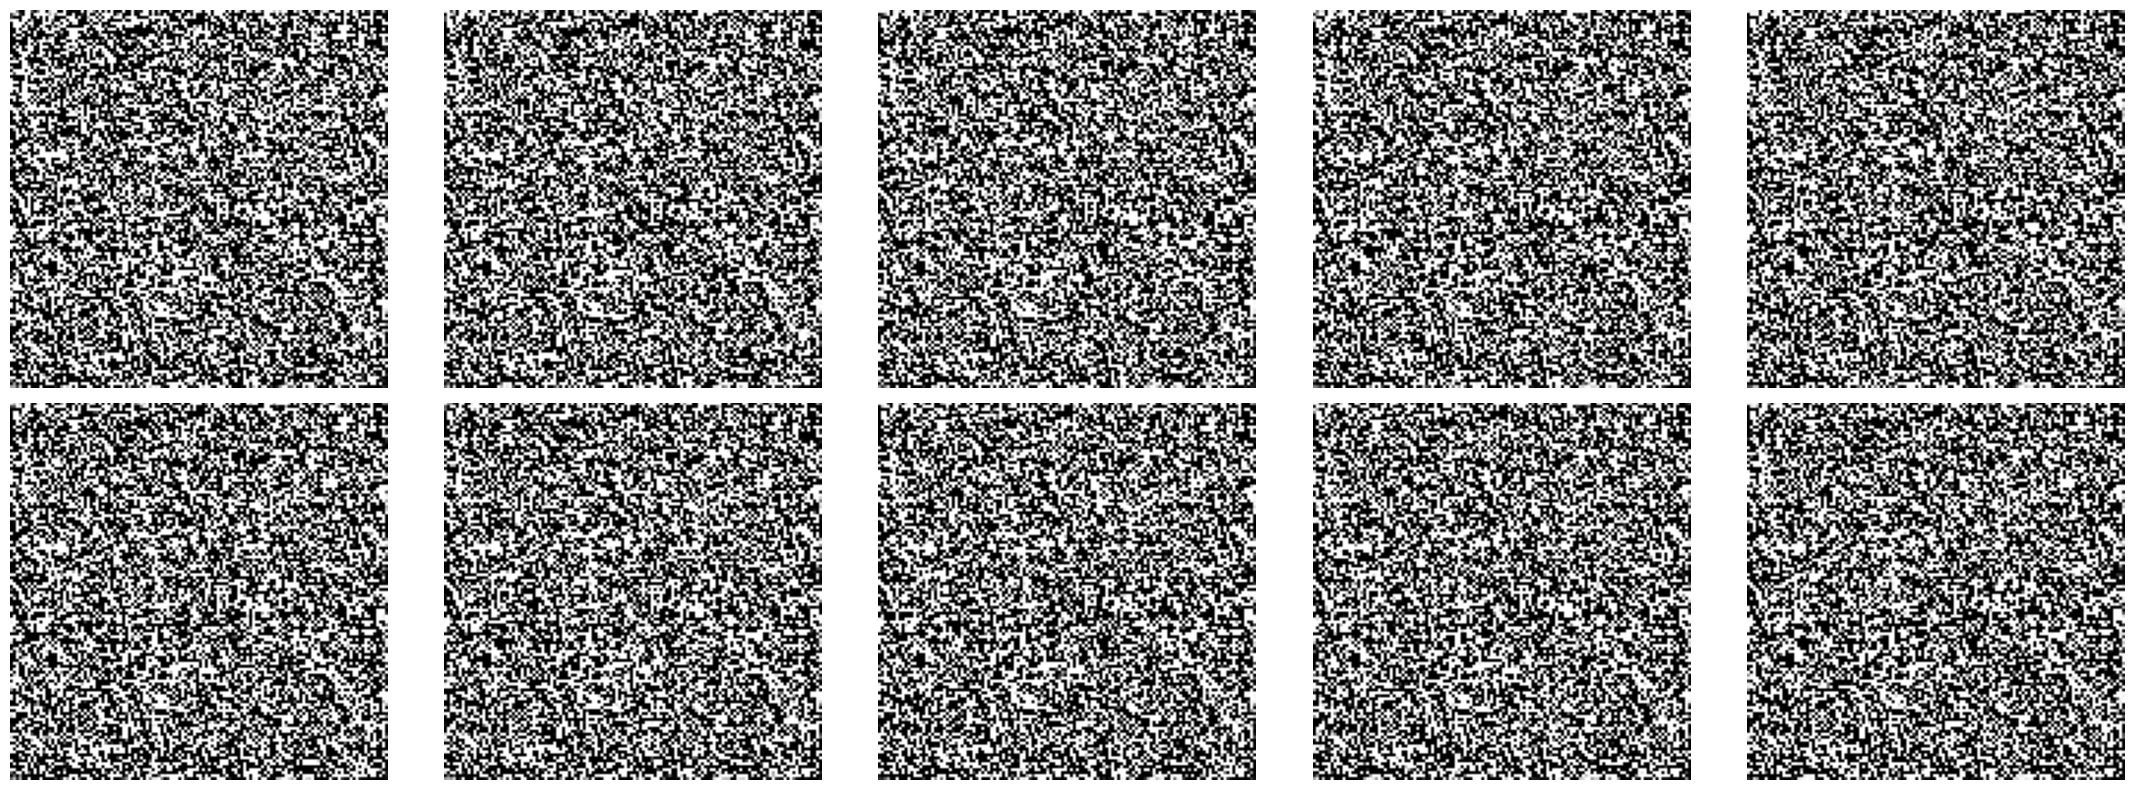

  0%|                                                 | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  0%|                                       | 1/2000 [00:03<1:43:56,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


  0%|                                       | 2/2000 [00:05<1:37:09,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


  0%|                                       | 3/2000 [00:08<1:38:41,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  0%|                                       | 4/2000 [00:11<1:38:52,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


  0%|                                       | 5/2000 [00:14<1:35:52,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


  0%|                                       | 6/2000 [00:17<1:34:56,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  0%|                                       | 6/2000 [00:20<1:50:58,  3.34s/it]

KeyboardInterrupt



In [14]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    # print(g_loss)
    # print(d_loss)

    #print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))